In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 6545018

- also known as TIC 169820995 

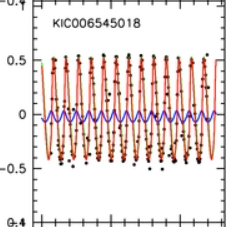

(x, time-span: ~1300 d ; y, O-C in kilosecs)

Source:  `2013ApJ...768...33R` [Triple-star Candidates among the Kepler Binaries](https://ui.adsabs.harvard.edu/abs/2013ApJ...768...33R/abstract) 


In [3]:
# define the plotting parameters

figsize = (8,4)

In [10]:
# import the data

# choose a TIC ID to analyze
ticid = 169820995 
kicid = 6545018  # ETV amplitude 1000s
# reference: 2013ApJ
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u



sr = lk.search_lightcurve('KIC{}'.format(kicid))
sr = sr[sr.exptime == 1800 * u.s]  # exclude 1 quarter that has both 30min and 1min cadence data
sr = lke._sort_chronologically(sr)
display(sr)
lcc_kplr = sr.download_all()
lc_kplr = lcc_kplr[:].stitch()
lc_kplr.time.format = "mjd"  # to be consistent with the paper result, also for ease of combining with TESS data
lc_kplr = lc_kplr.truncate(None, 55800)  # test with a few ETV cycles based on reference plot

# sr = lk.search_lightcurve('TIC {}'.format(ticid), )  # all available TESS sectors has only QLP data for this target
# sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
# sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
# display(sr)
# lc_tess = sr.download_all().stitch()
# lc_tess.time.format = "mjd"

search_result = lk.LightCurveCollection([
    lc_kplr,
    # lc_tess,
]).stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 17 data products.

 #       mission      year author exptime  target_name  distance proposal_id
                                     s                   arcsec             
--- ----------------- ---- ------ ------- ------------- -------- -----------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr006545018      0.0          EX
  1 Kepler Quarter 02 2009 Kepler    1800 kplr006545018      0.0          EX
  2 Kepler Quarter 03 2009 Kepler    1800 kplr006545018      0.0          EX
  3 Kepler Quarter 04 2010 Kepler    1800 kplr006545018      0.0          EX
  4 Kepler Quarter 05 2010 Kepler    1800 kplr006545018      0.0          EX
  5 Kepler Quarter 06 2010 Kepler    1800 kplr006545018      0.0          EX
  6 Kepler Quarter 07 2010 Kepler    1800 kplr006545018      0.0          EX
  7 Kepler Quarter 08 2011 Kepler    1800 kplr006545018      0.0          EX
  8 Kepler Quarter 09 2011 Kepler    1800 kplr006545018      0.0          EX
  9 Kepler Quarter 10 2011 Kepler    1800 kplr006545018      0.0          EX
 10 Kepler Quarter 11 2012 Kepler    1800 kplr006545018      0.0          EX
 11 Kepler Quarter 12 2012 Kepler    1800 kplr006545018      0.0          EX
 12 Kepler Quarter 13 2012 Kepler    1800 kplr006545018      0.0          EX
 13 Kepler Quarter 14 2012 Kepler    1800 kplr006545018      0.0          EX
 14 Kepler Quarter 15 2013 Kepler    1800 kplr006545018      0.0          EX
 15 Kepler Quarter 16 2013 Kepler    1800 kplr006545018      0.0          EX
 16 Kepler Quarter 17 2013 Kepler    1800 kplr006545018      0.0          EX

37582

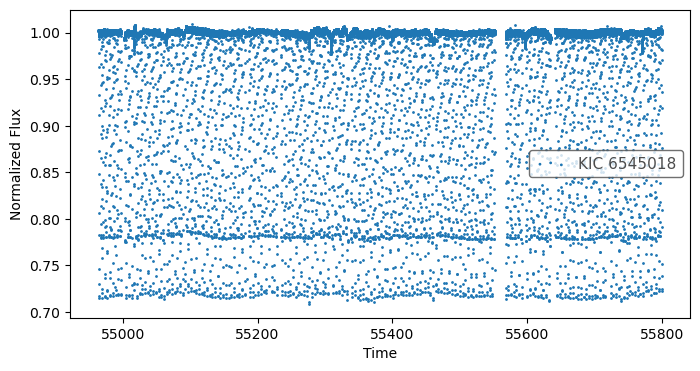

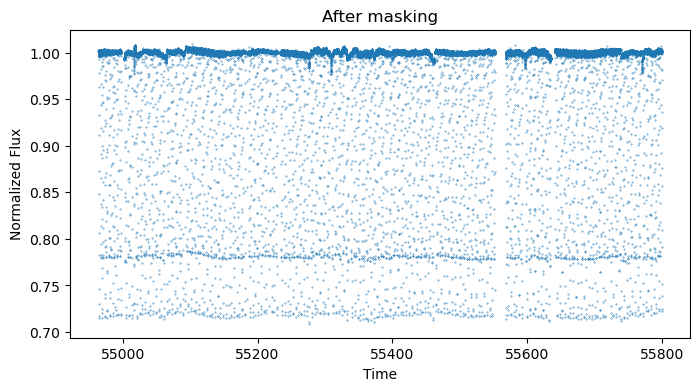

In [11]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

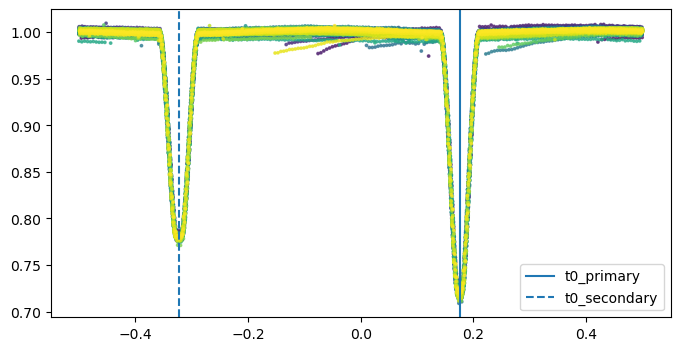

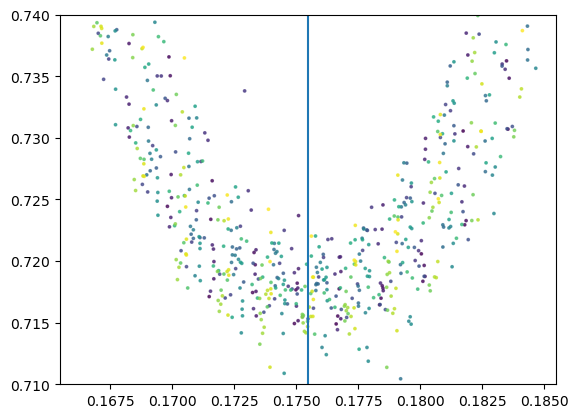

In [15]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# period = 3.9914603  # Kepler EB Period
period = 3.99146  # 2013ApJ Period


t0_primary = 54965.835642 - 0.5  # Kepler EB, the MJD there seems to be off by 0.5
t0_secondary = t0_primary + period * 0.5013


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 0.0530 * period * 24  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 0.0571 * period * 24  

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.35  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.01, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.01);
plt.ylim(0.71, 0.74);
plt.show()

### Now that the data is ready we can start 

In [16]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0      54964.011994  1.002106  0.000147 -0.156165
1      54964.032429  1.001981  0.000147 -0.151045
2      54964.052863  1.002445  0.000147 -0.145926
3      54964.073298  1.002443  0.000147 -0.140806
4      54964.093732  1.002116  0.000147 -0.135687
...             ...       ...       ...       ...
37526  55799.912289  1.001982  0.000159  0.266025
37527  55799.932723  1.002348  0.000159  0.271144
37528  55799.953156  1.002881  0.000159  0.276264
37529  55799.973590  1.001993  0.000159  0.281383
37530  55799.994023  1.002434  0.000159  0.286502

[37531 rows x 4 columns]

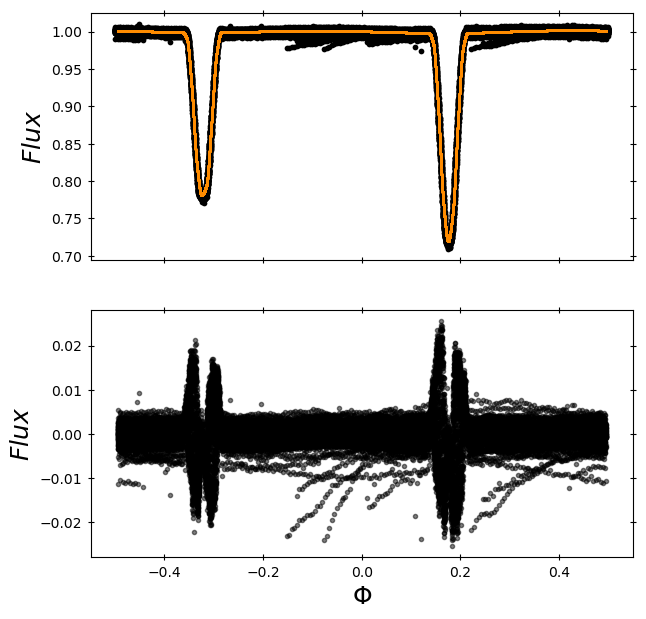

time      flux       err     phase  flux_sub_binary  \
0      54964.011994  1.002106  0.000147 -0.156165         0.001368   
1      54964.032429  1.001981  0.000147 -0.151045         0.001177   
2      54964.052863  1.002445  0.000147 -0.145926         0.001565   
3      54964.073298  1.002443  0.000147 -0.140806         0.001558   
4      54964.093732  1.002116  0.000147 -0.135687         0.001231   
...             ...       ...       ...       ...              ...   
37526  55799.912289  1.001982  0.000159  0.266025         0.002846   
37527  55799.932723  1.002348  0.000159  0.271144         0.003105   
37528  55799.953156  1.002881  0.000159  0.276264         0.003512   
37529  55799.973590  1.001993  0.000159  0.281383         0.002455   
37530  55799.994023  1.002434  0.000159  0.286502         0.002749   

       binary_model  
0          1.000738  
1          1.000803  
2          1.000880  
3          1.000884  
4          1.000885  
...             ...  
37526      0.999136  
37527      0.999243  
37528      0.999368  
37529      0.999538  
37530      0.999685  

[37531 rows x 6 columns]

In [17]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 37150 901
reached the end
10 32548 901
reached the end
10 32014 901
reached the end
10 31900 901
reached the end
10 31875 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      54964.011994  1.002106  0.000147 -0.156165         0.001368   
1      54964.032429  1.001981  0.000147 -0.151045         0.001177   
2      54964.052863  1.002445  0.000147 -0.145926         0.001565   
3      54964.073298  1.002443  0.000147 -0.140806         0.001558   
4      54964.093732  1.002116  0.000147 -0.135687         0.001231   
...             ...       ...       ...       ...              ...   
37526  55799.912289  1.001982  0.000159  0.266025         0.002846   
37527  55799.932723  1.002348  0.000159  0.271144         0.003105   
37528  55799.953156  1.002881  0.000159  0.276264         0.003512   
37529  55799.973590  1.001993  0.000159  0.281383         0.002455   
37530  55799.994023  1.002434  0.000159  0.286502         0.002749   

       binary_model  flux_detrended  
0          1.000738        1.000738  
1          1.000803        1.000620  
2          1.000880        1.001091  
3          1.000884        1.001095  
4          1.000885        1.000776  
...             ...             ...  
37526      0.999136        0.999200  
37527      0.999243        0.999561  
37528      0.999368        1.000088  
37529      0.999538        0.999195  
37530      0.999685        0.999632  

[37531 rows x 7 columns]

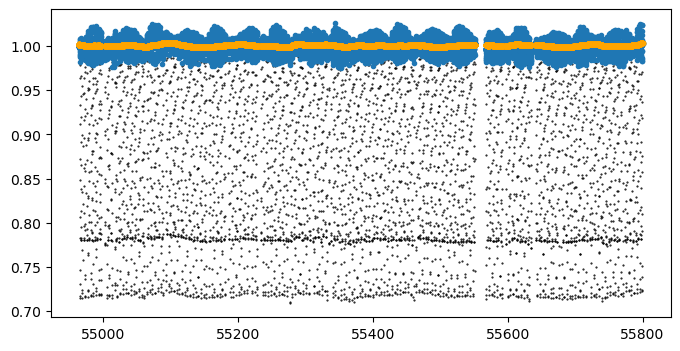

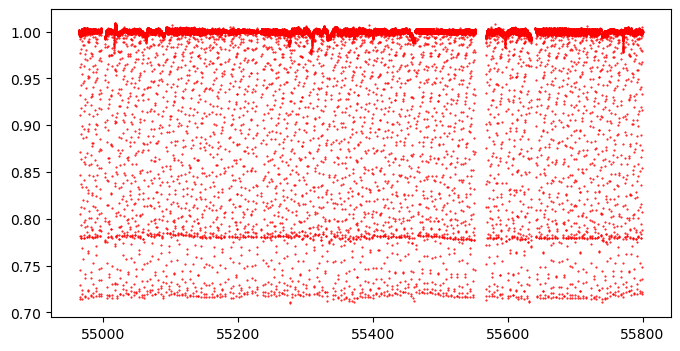

In [18]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

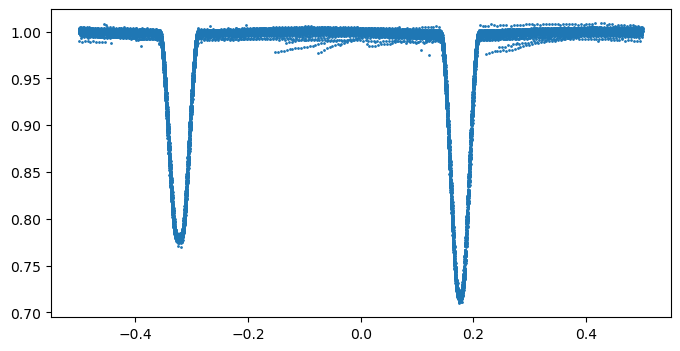

In [19]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   54965.335642 0.17545499999961056
window_width_p (phase): 0.0583
Secondary: 54967.336560897995 -0.3232450000012417
window_width_s (phase): 0.06281


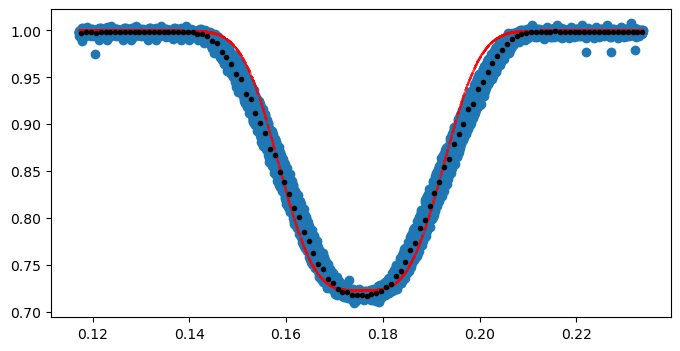

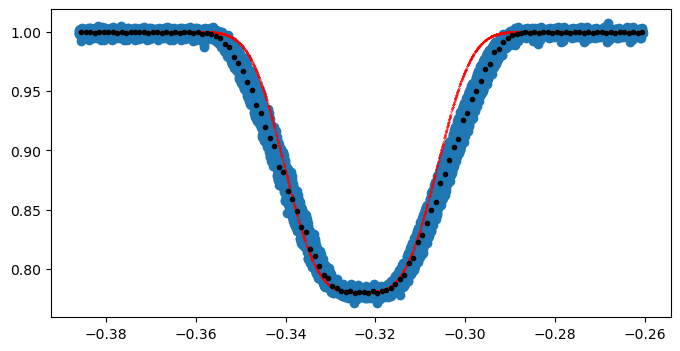

In [28]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.1 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    window_width_s = 1.1 * duration_hr_secondary / 24 / period
    # window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.00, -0.2768, midpoint_p, 0.012, 2.0]
start_vals_s = [1.00, -0.2192, midpoint_s, 0.012, 2.0]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.62it/s]


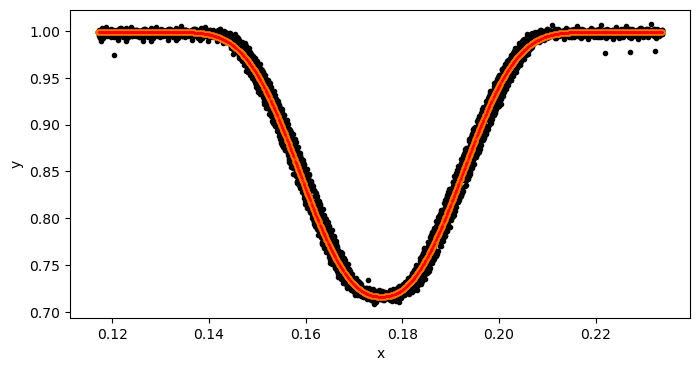

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:05<00:00,  5.39it/s]


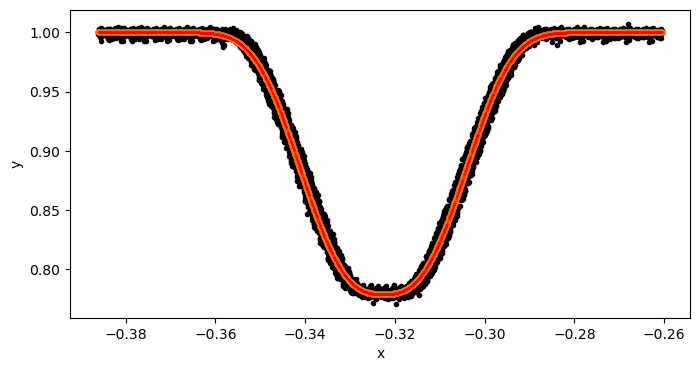

In [29]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")

    # initial fit params from Kepler data (<MJD 55800) 2013Apj Period
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9992243926743156, -0.28289019141999194, 0.1756269273273081, 0.01465780655811189, 1.1695489103484835
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0000198023838813, -0.2209161523632035, -0.32261651494994603, 0.0146190296934322, 1.4343919805279435

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [31]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9992243926743156, -0.28289019141999194, 0.1756269273273081, 0.01465780655811189, 1.1695489103484835
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0000198023838813, -0.2209161523632035, -0.32261651494994603, 0.0146190296934322, 1.4343919805279435


209

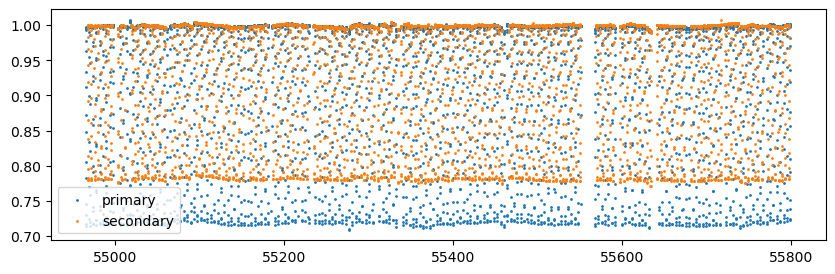

In [32]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

54965.335642 3.99146 54965.335642


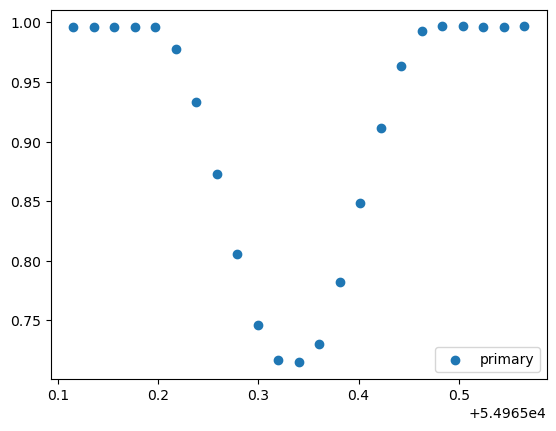

54965.335642 3.99146 54969.327101999996


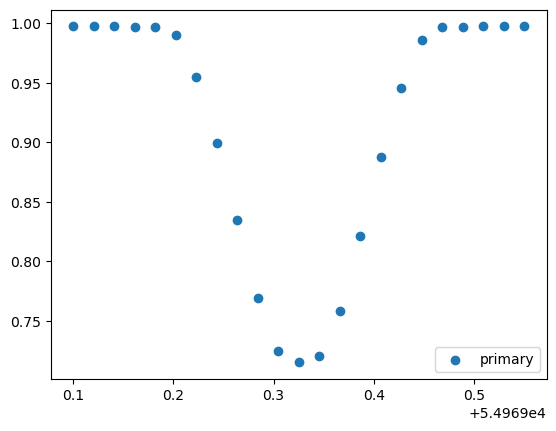

54965.335642 3.99146 54973.318562


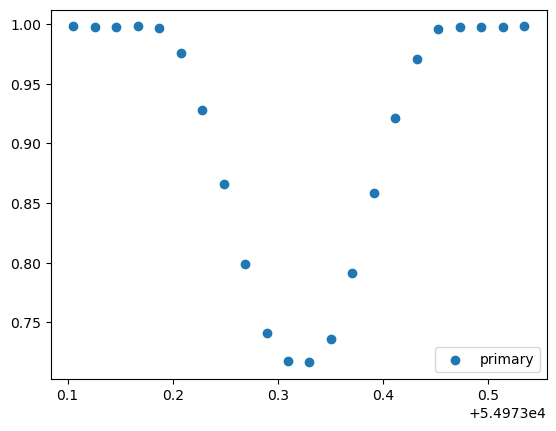

54967.336560897995 3.99146 54967.336560897995


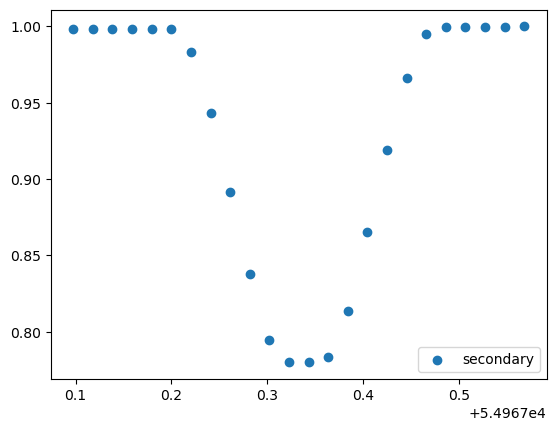

54967.336560897995 3.99146 54971.32802089799


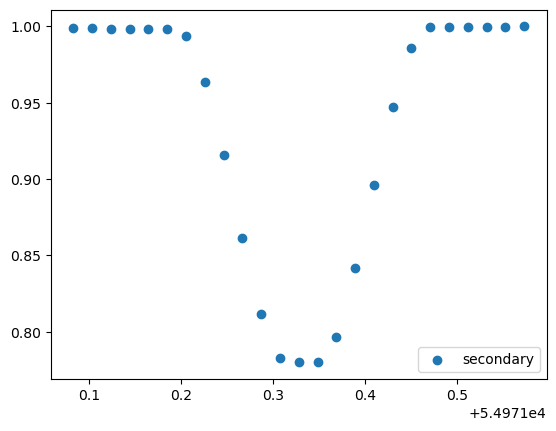

54967.336560897995 3.99146 54975.319480898


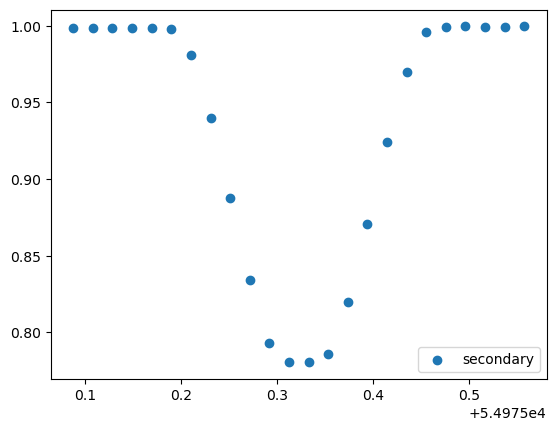

In [33]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 14 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has already been completed -- skip
Number 20 has a

  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1267.90it/s]


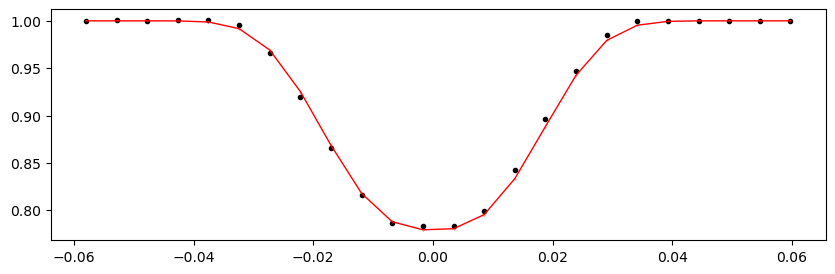

55039.18284089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1239.87it/s]


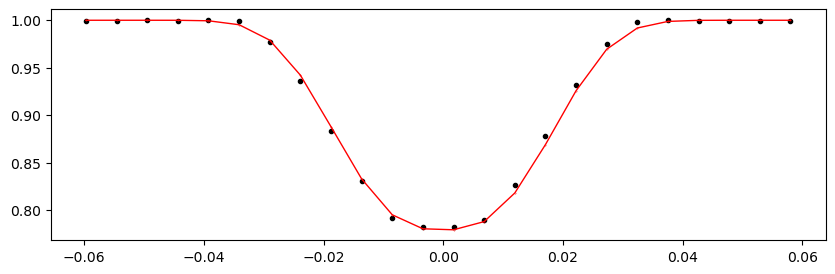

55043.174300898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.97it/s]


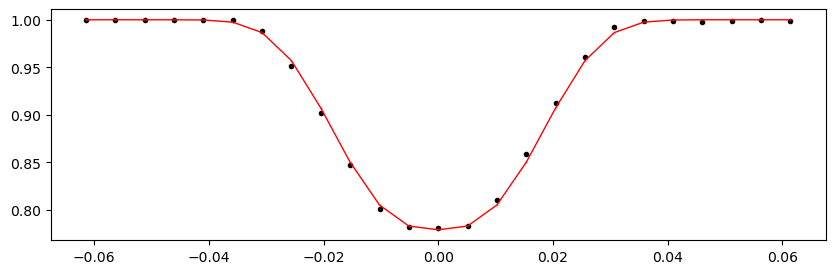

55047.165760897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1171.81it/s]


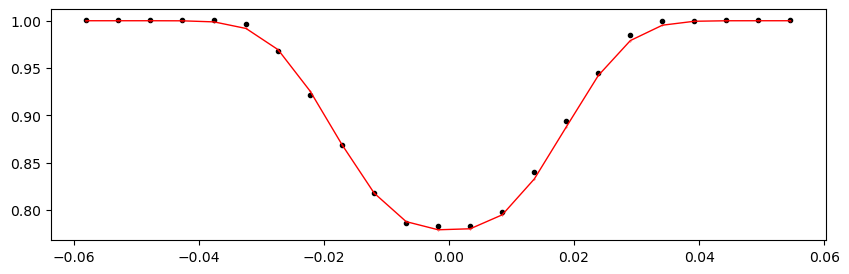

55051.15722089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1174.56it/s]


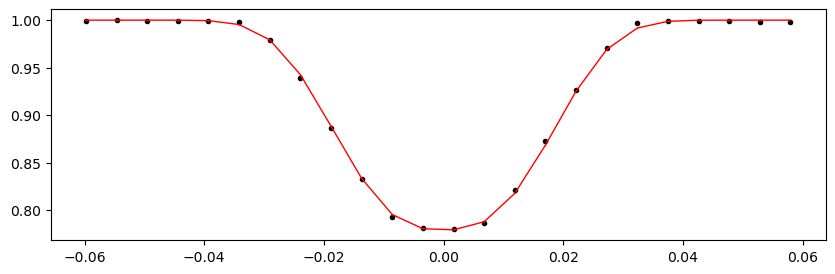

55055.148680898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1093.78it/s]


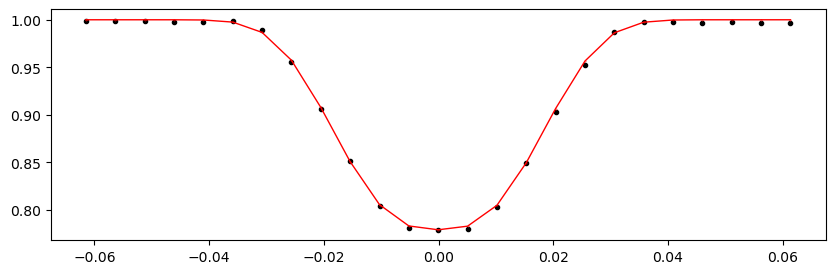

55059.140140897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1155.41it/s]


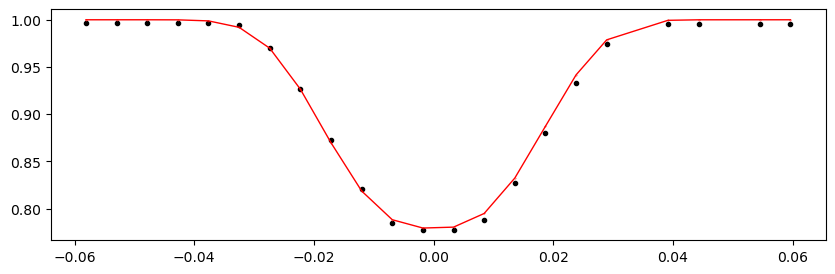

55067.123060898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.54it/s]


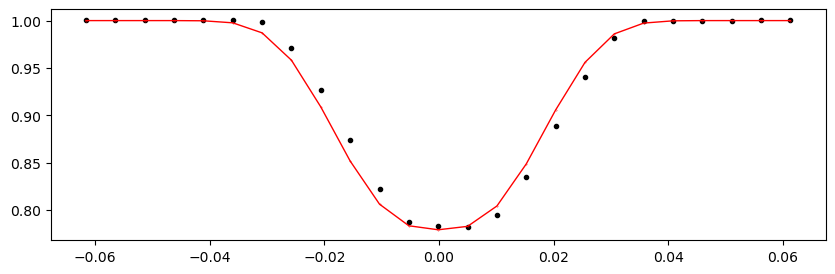

55071.114520897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1148.58it/s]


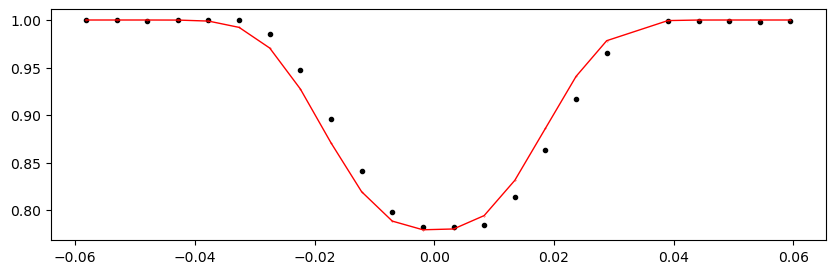

55075.10598089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1171.80it/s]


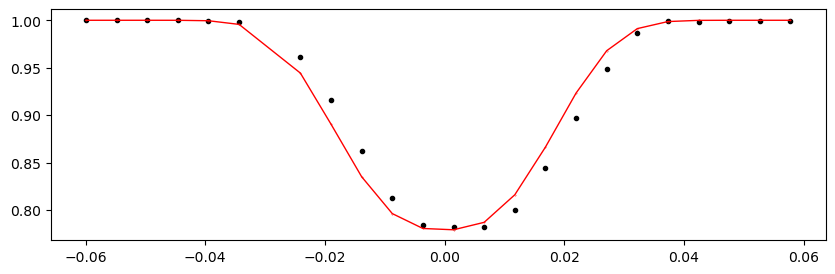

55079.097440898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.23it/s]


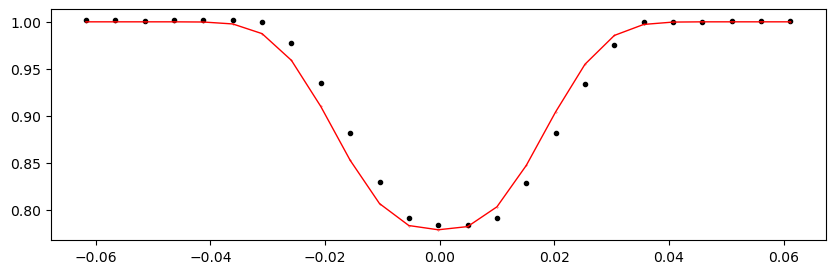

55083.088900897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1169.13it/s]


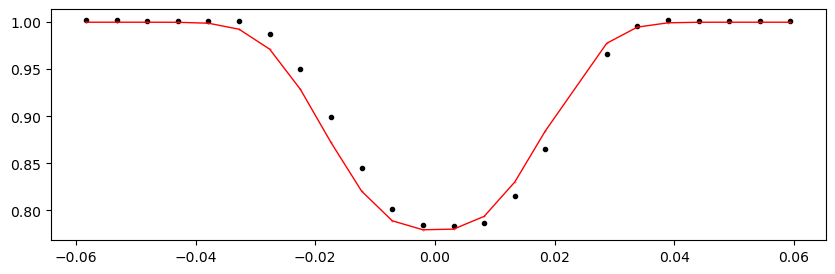

55087.08036089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.38it/s]


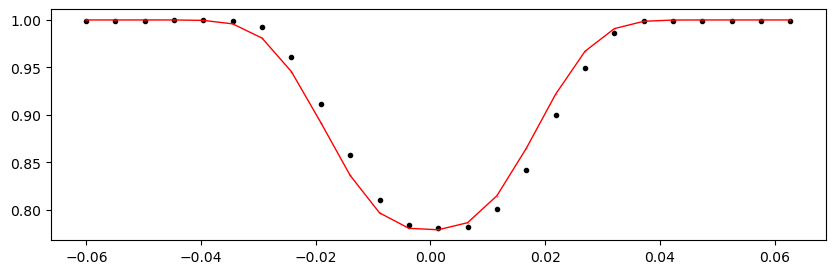

Time 55091.071820897996 does not have enough data points: 7
55095.06328089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1149.12it/s]


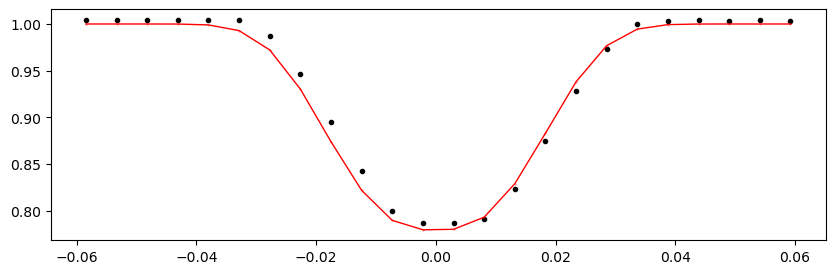

55099.054740898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.56it/s]


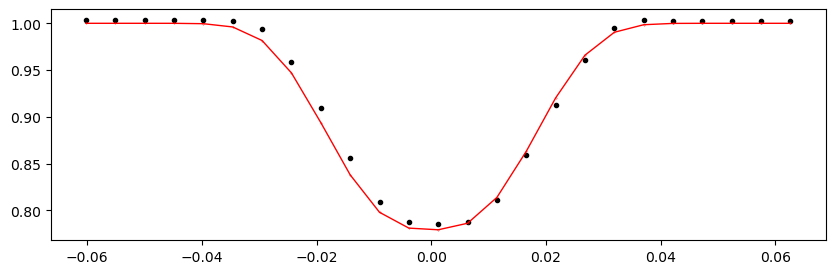

55103.046200897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.26it/s]


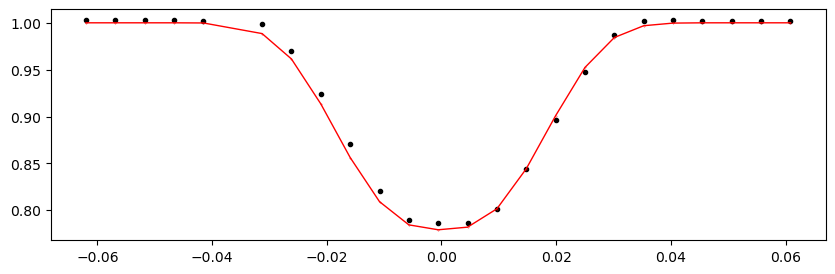

55107.03766089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.15it/s]


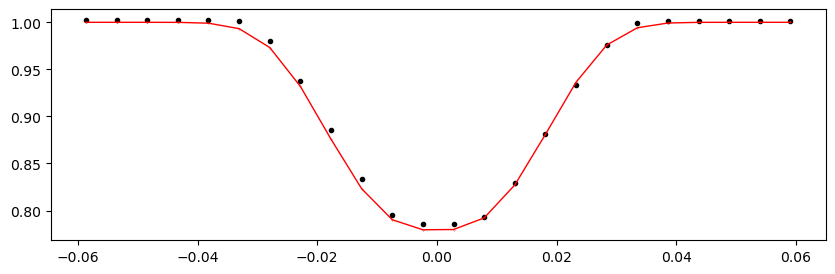

55111.029120898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.97it/s]


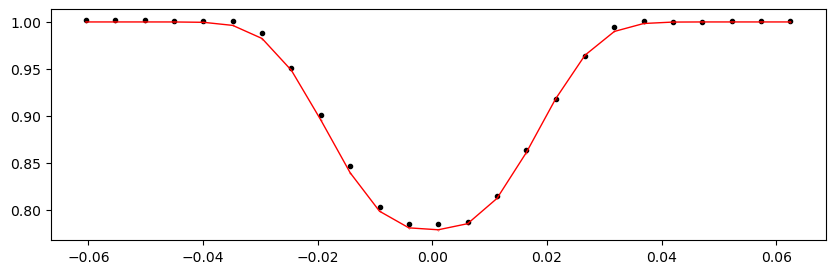

55115.020580897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.24it/s]


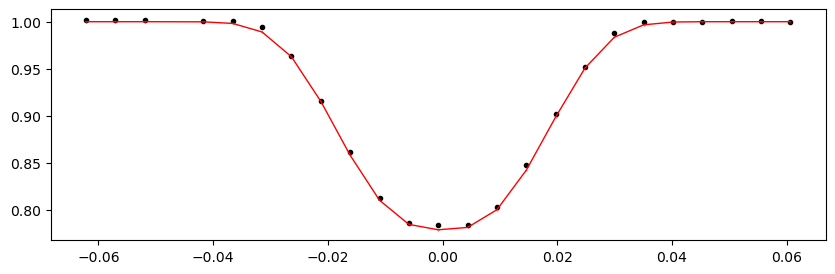

55119.01204089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1124.24it/s]


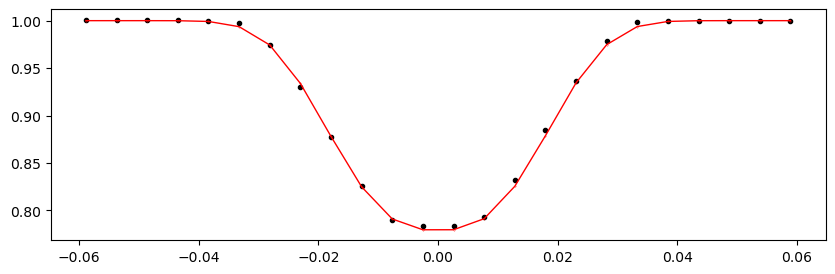

55123.003500898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 973.44it/s]


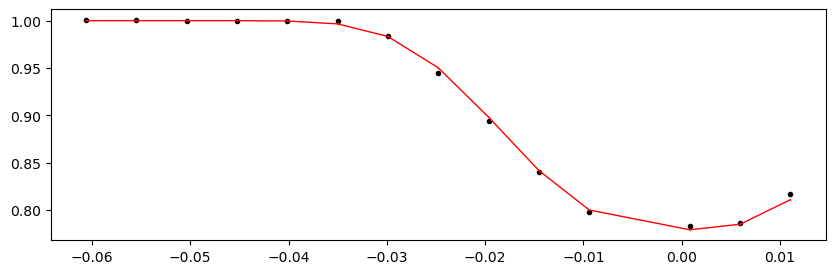

55126.994960897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1052.61it/s]


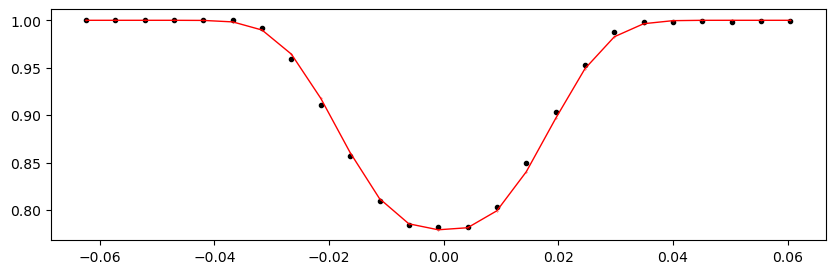

55130.98642089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.62it/s]


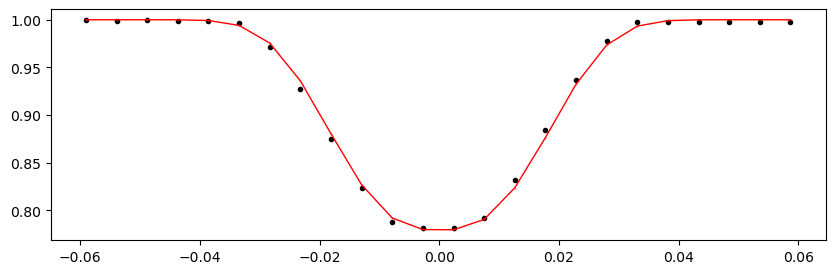

55134.977880898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.49it/s]


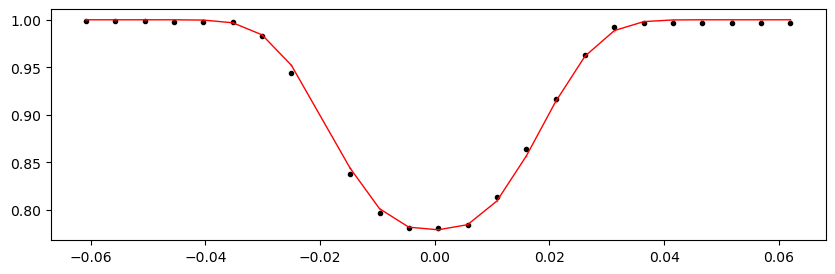

55138.969340897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.10it/s]


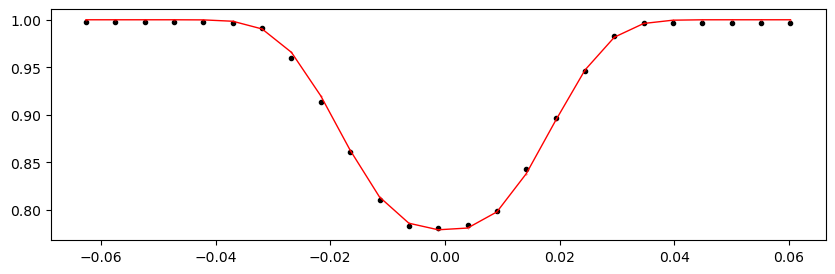

55142.96080089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.17it/s]


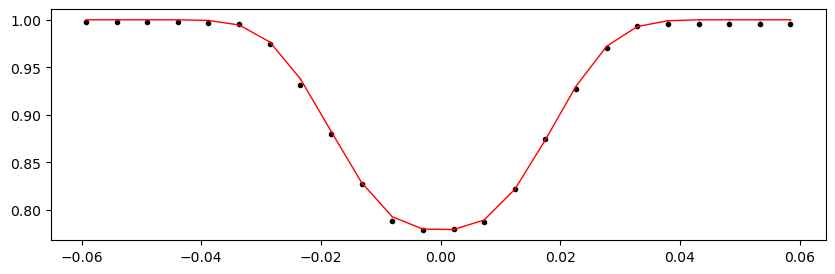

55146.952260898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.90it/s]


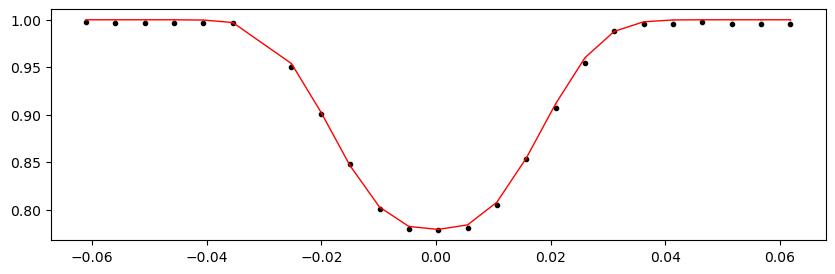

55150.943720897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.62it/s]


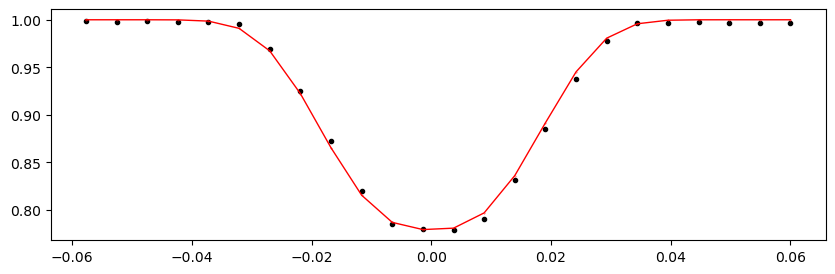

55158.926640898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1153.51it/s]


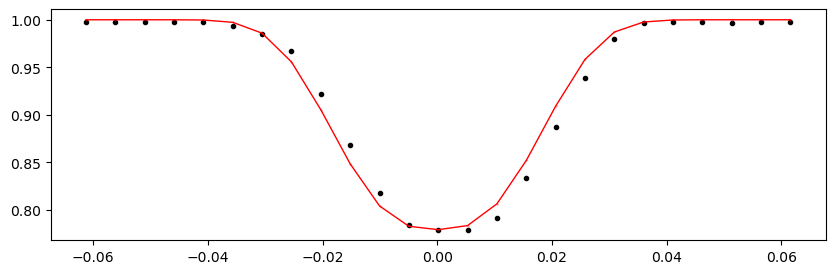

55162.918100897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.95it/s]


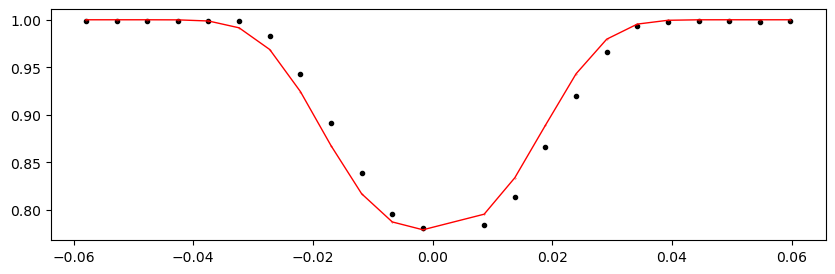

55166.90956089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1164.17it/s]


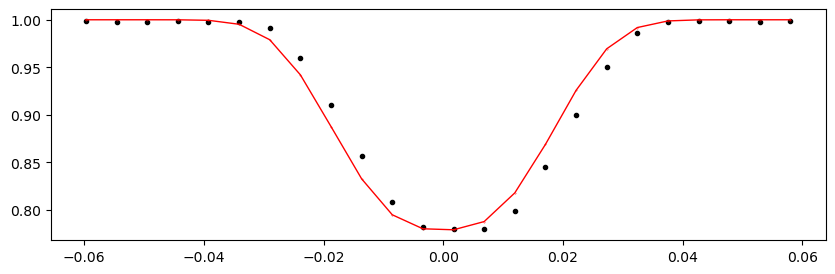

55170.901020897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.89it/s]


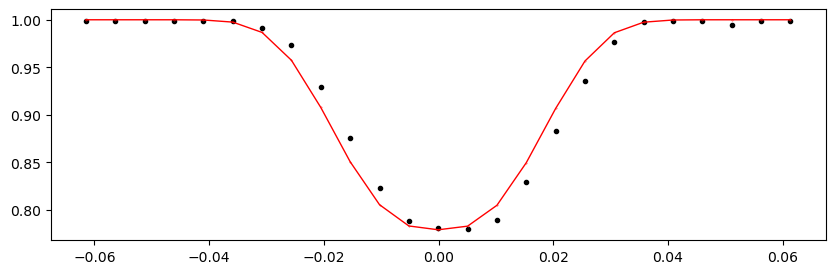

55174.892480897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1160.08it/s]


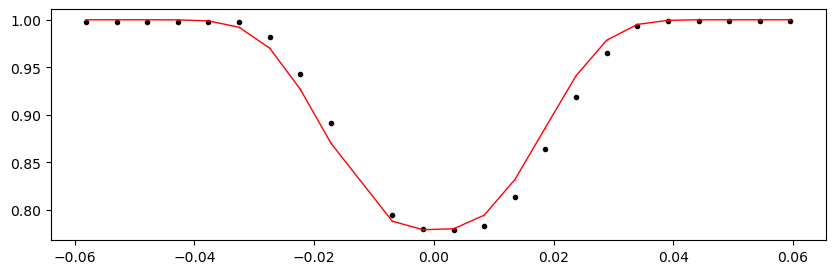

55178.883940898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1112.04it/s]


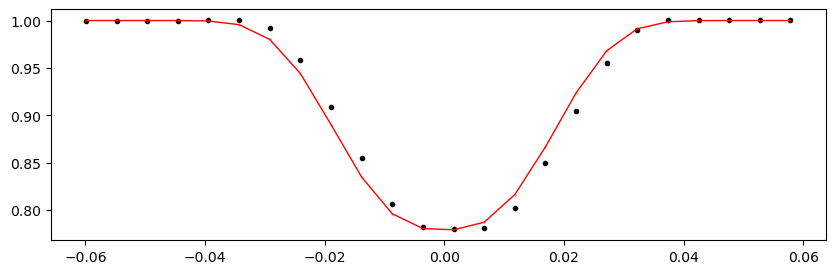

55186.86686089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1004.22it/s]


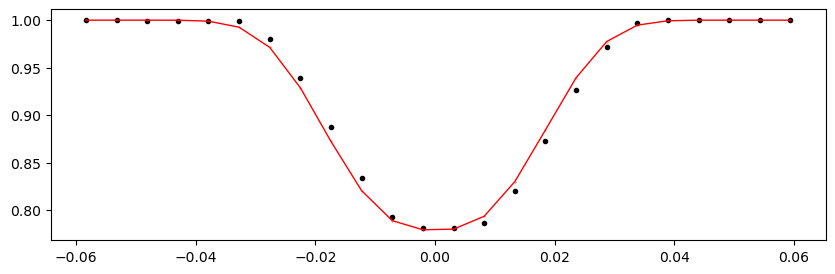

55190.858320898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 977.76it/s]


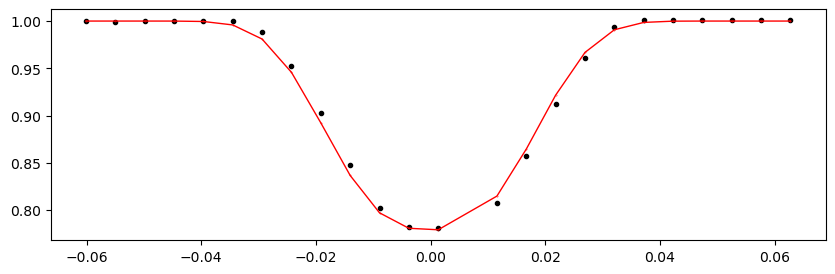

55194.849780897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.47it/s]


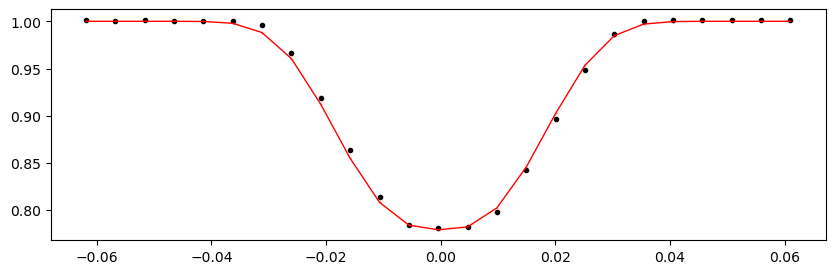

55198.84124089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1126.49it/s]


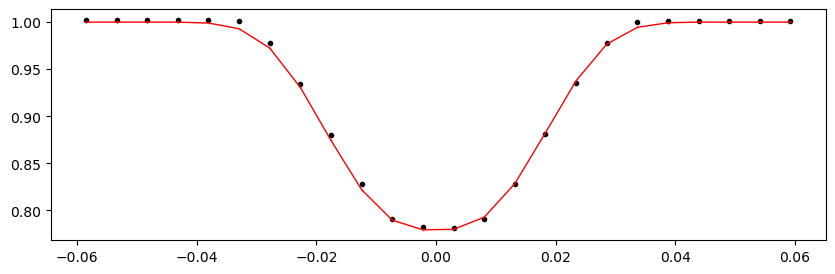

55202.832700898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.53it/s]


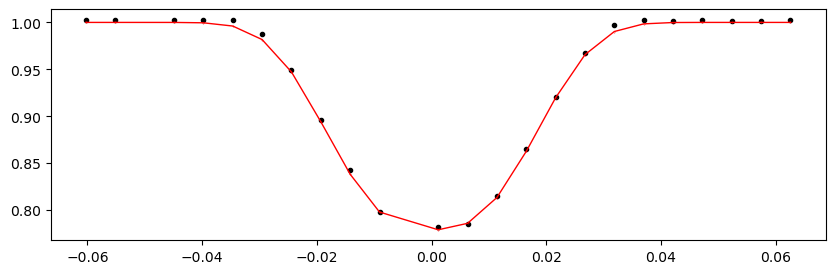

55206.824160897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.98it/s]


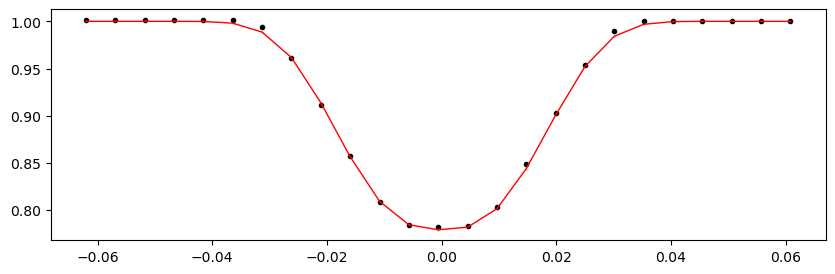

55210.81562089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.31it/s]


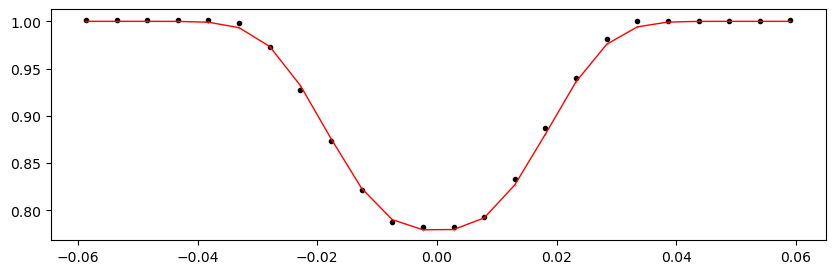

55214.807080898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1126.08it/s]


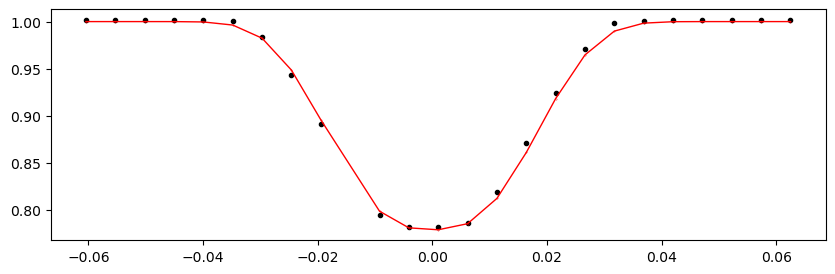

55218.798540897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1160.46it/s]


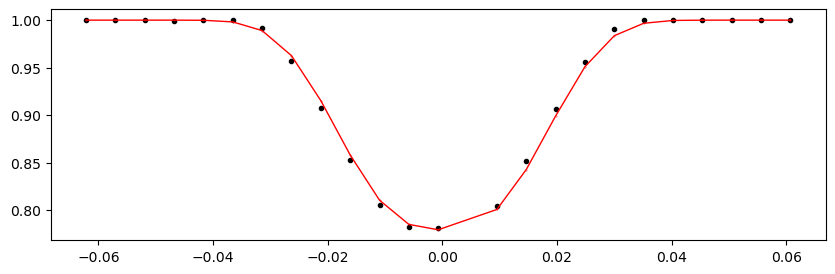

55222.79000089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1126.53it/s]


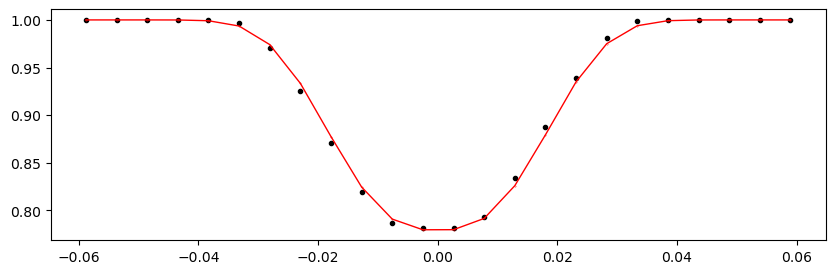

55226.781460898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.55it/s]


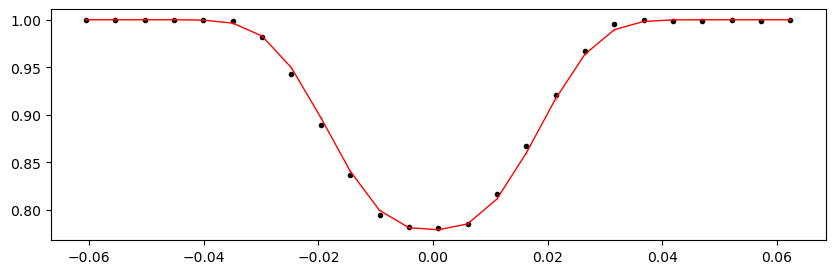

55234.76438089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1175.78it/s]


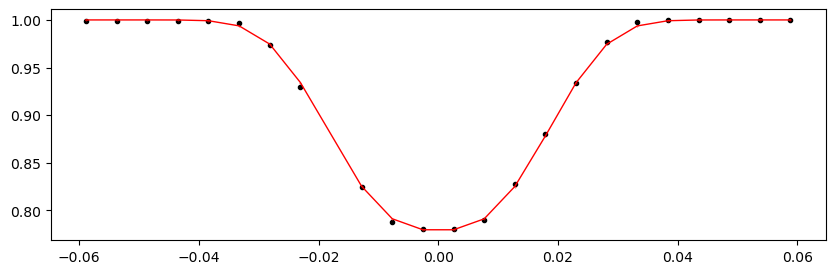

55238.755840898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1189.10it/s]


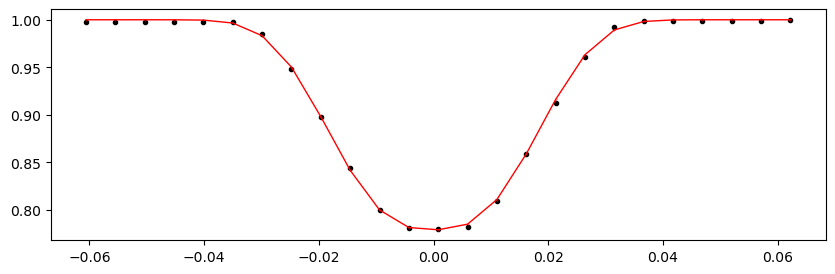

55242.747300897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1174.77it/s]


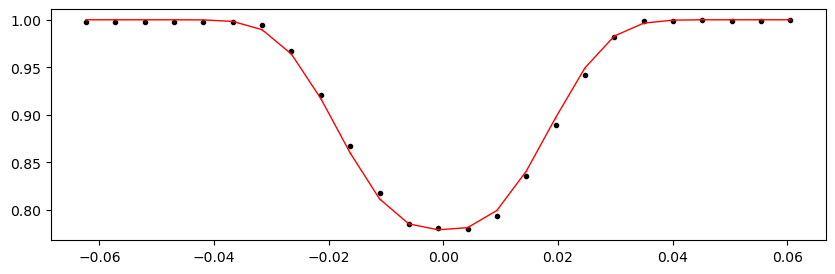

55246.73876089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1174.35it/s]


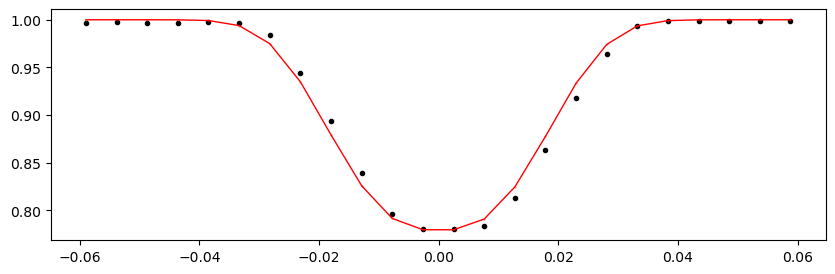

55250.730220897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.37it/s]


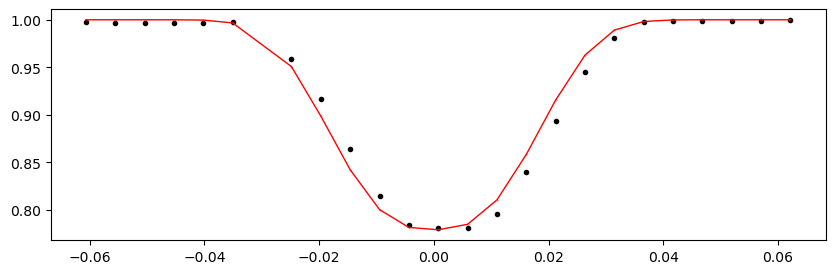

55254.721680897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1149.99it/s]


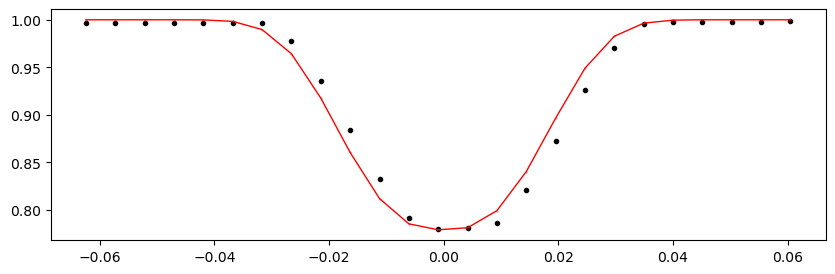

55258.71314089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.77it/s]


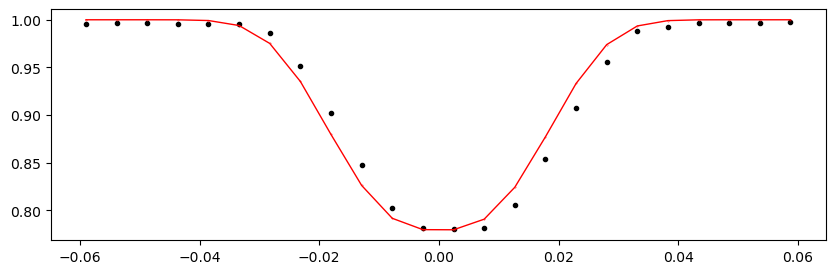

55262.704600897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1173.07it/s]


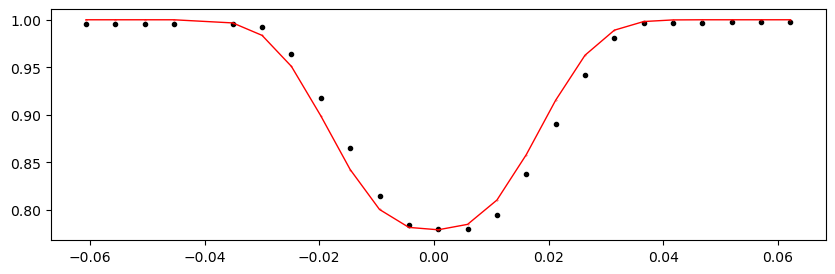

55266.69606089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1155.38it/s]


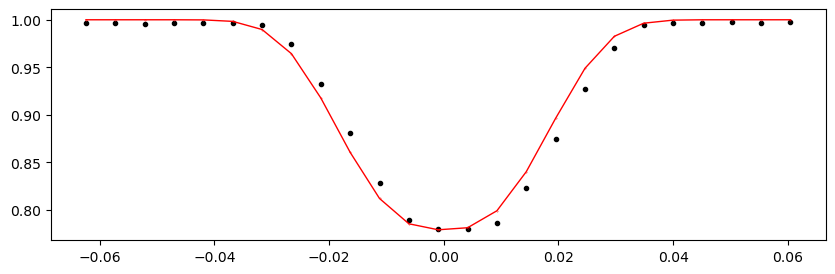

55270.687520898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.96it/s]


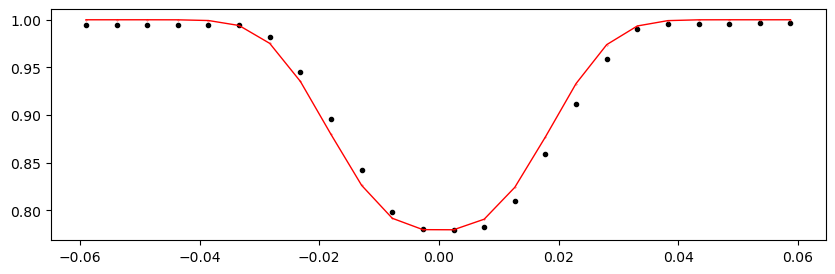

55274.678980897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.24it/s]


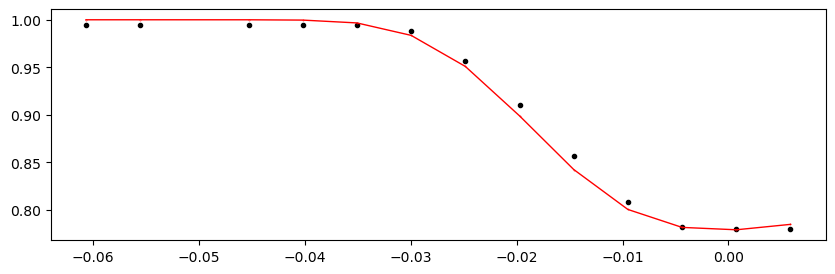

55278.67044089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.62it/s]


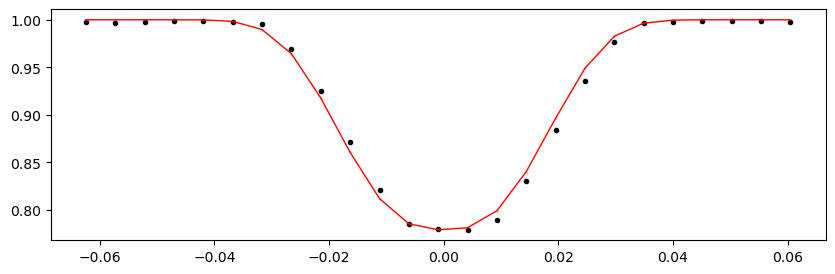

55282.661900898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.56it/s]


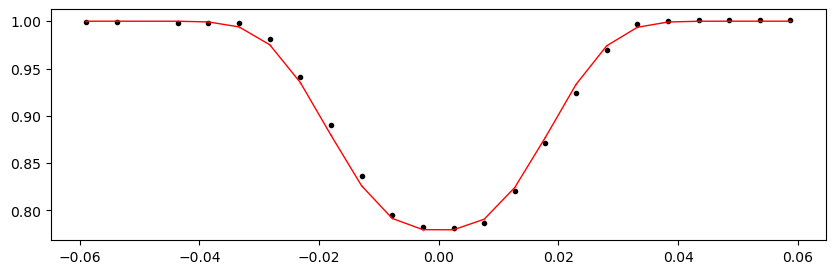

55286.653360897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1172.33it/s]


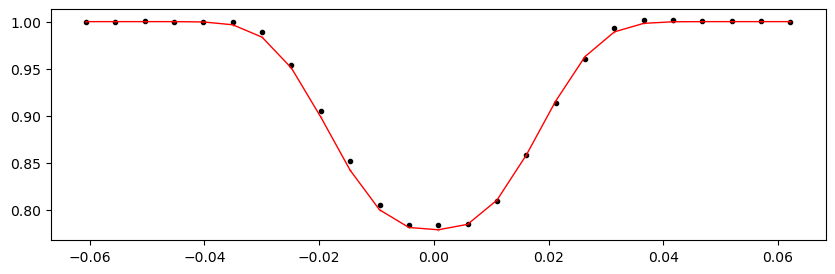

55290.64482089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1094.34it/s]


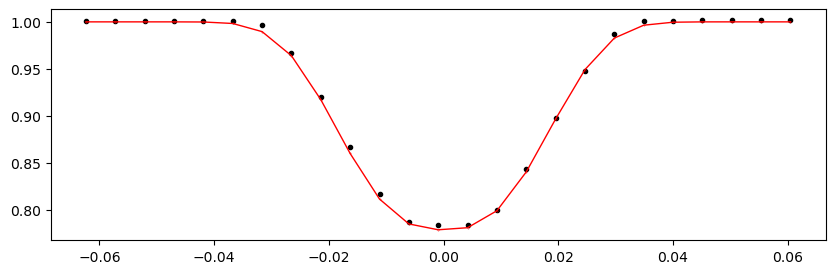

55294.636280898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 868.80it/s]


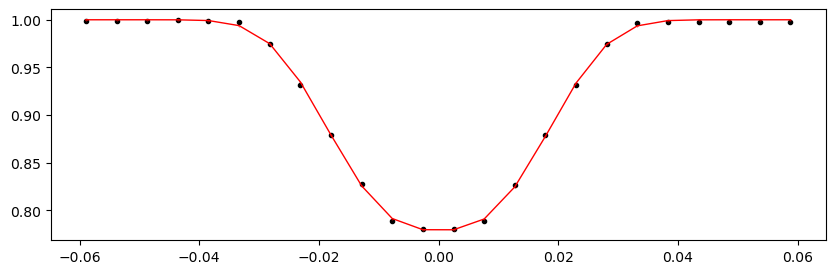

55298.627740897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1102.04it/s]


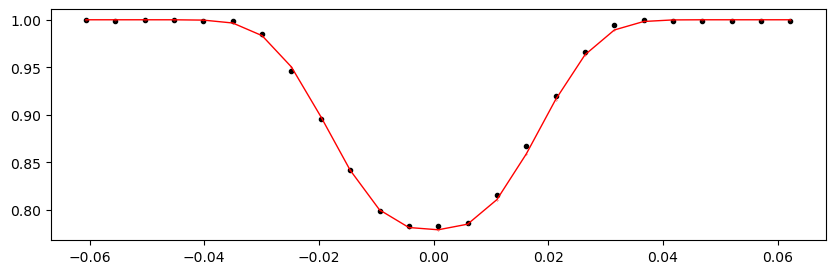

55302.61920089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.13it/s]


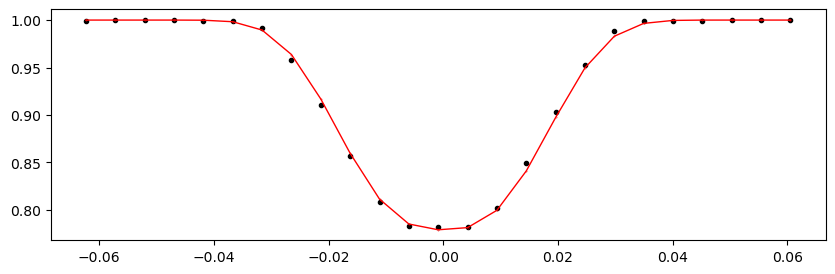

55306.610660898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1042.09it/s]


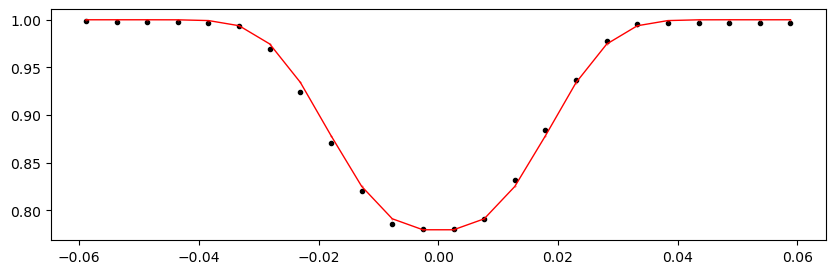

55310.602120897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1119.79it/s]


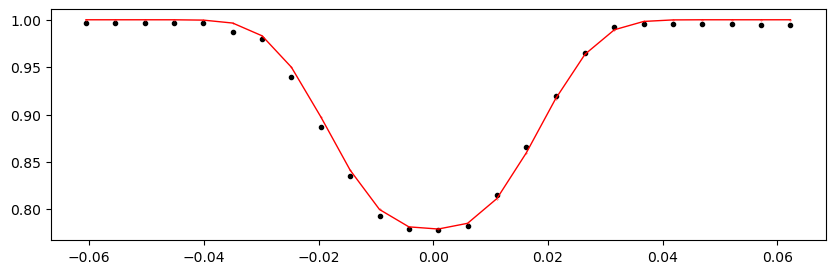

55314.59358089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1117.71it/s]


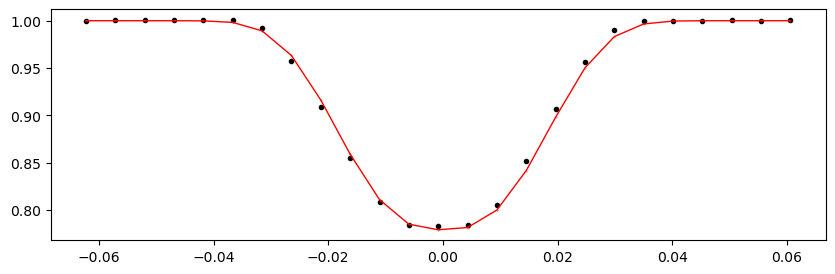

55318.585040898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 949.53it/s]


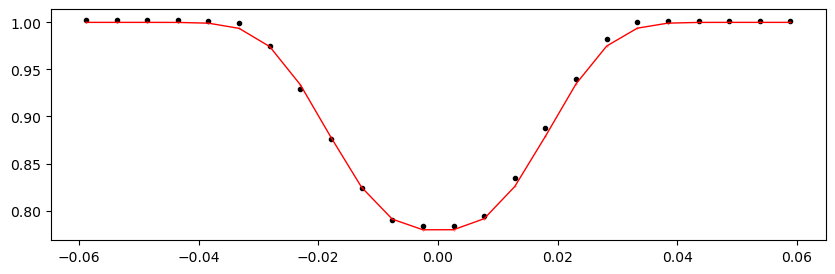

55322.576500897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1017.04it/s]


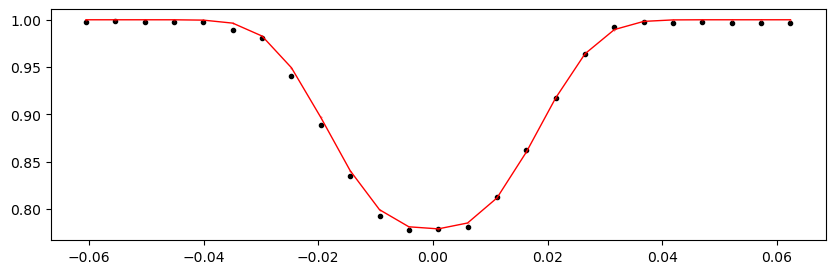

55326.56796089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 967.00it/s]


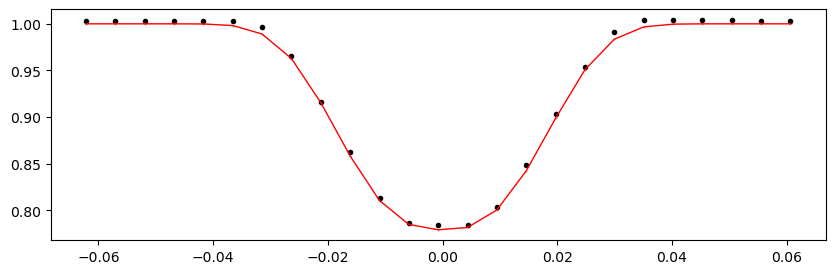

55330.559420898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|███████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 938.84it/s]


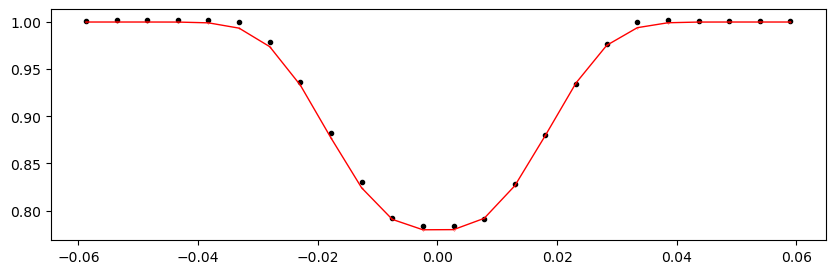

55334.550880897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1027.21it/s]


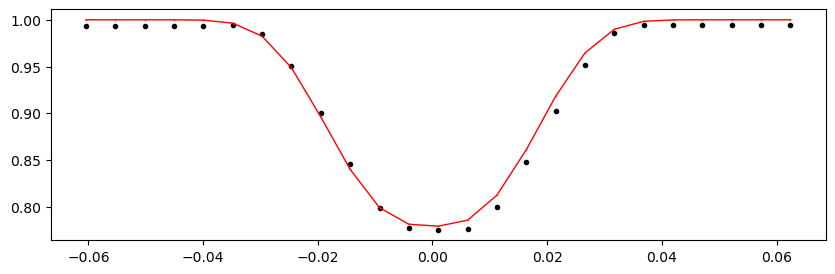

55338.54234089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1275.32it/s]


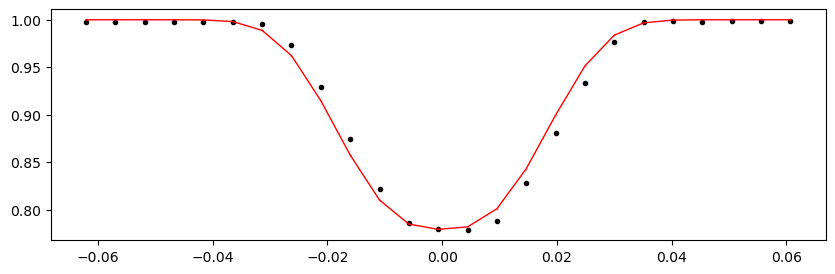

55342.533800897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1288.97it/s]


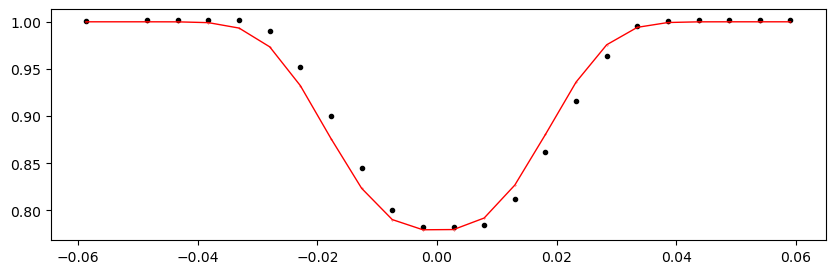

55346.52526089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1268.54it/s]


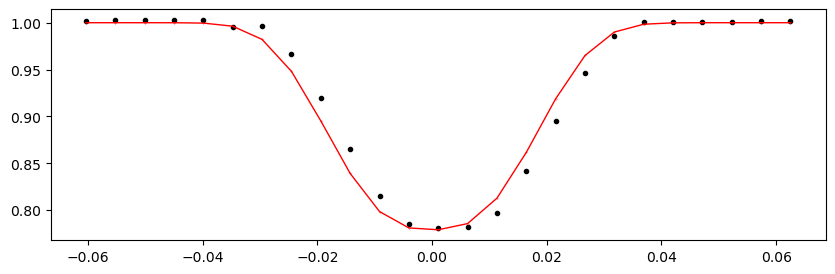

55350.516720898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1278.08it/s]


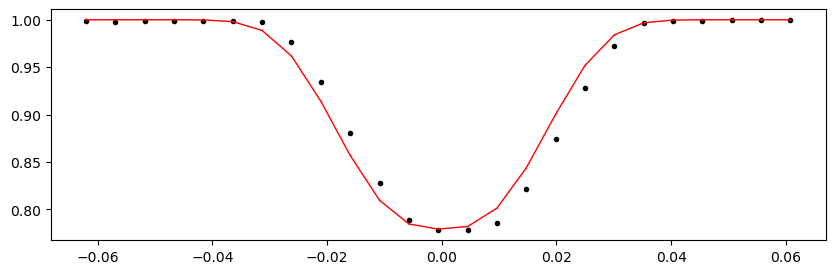

55354.508180897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1280.43it/s]


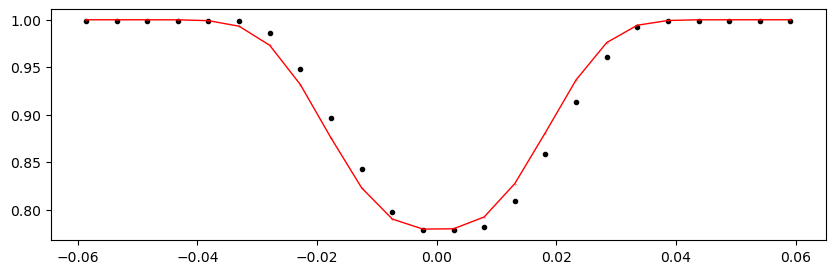

55358.49964089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1251.98it/s]


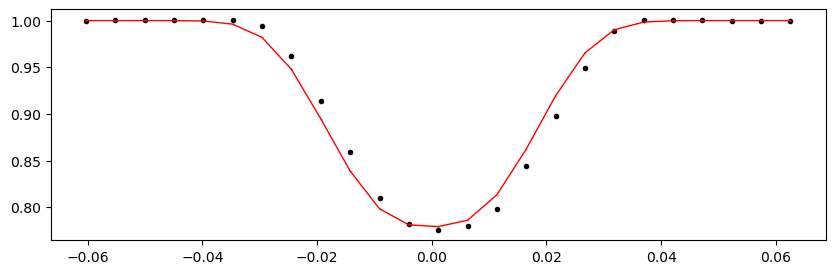

55362.491100898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1289.40it/s]


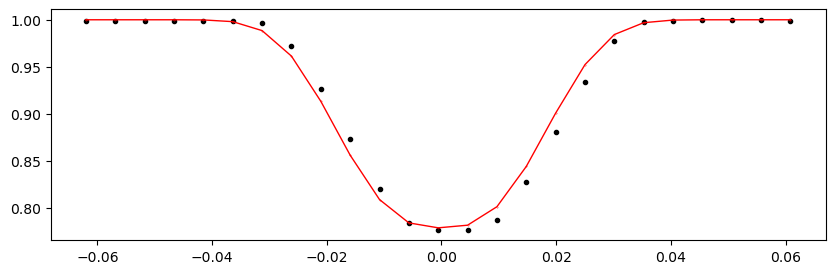

55366.482560897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1272.14it/s]


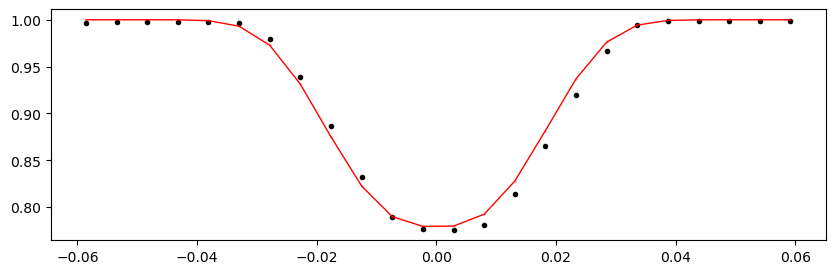

55370.47402089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1283.43it/s]


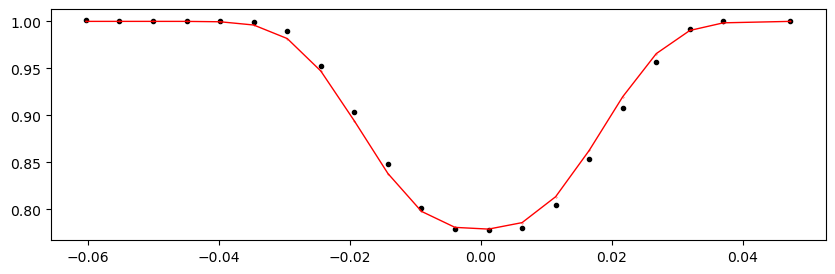

55374.465480898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1249.37it/s]


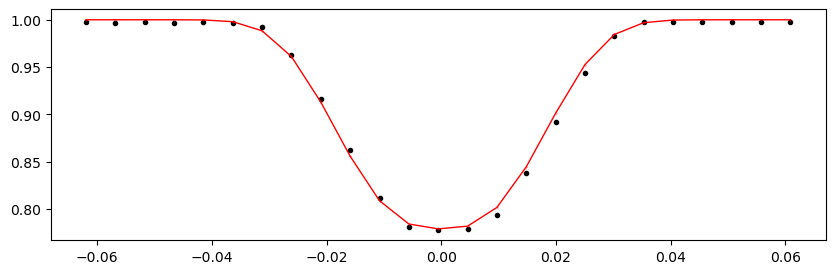

55378.456940897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1260.25it/s]


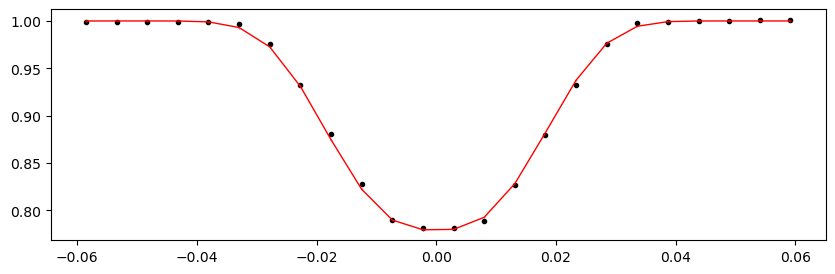

55382.44840089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1286.05it/s]


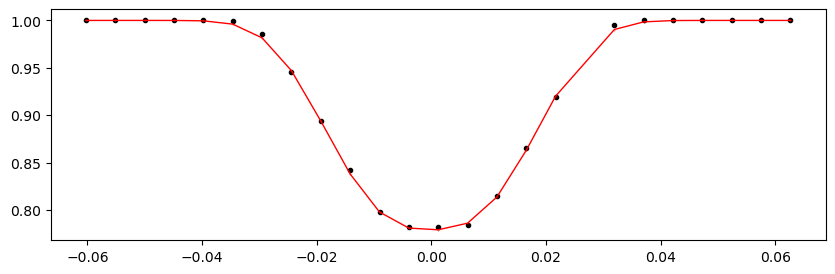

55386.439860898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1265.80it/s]


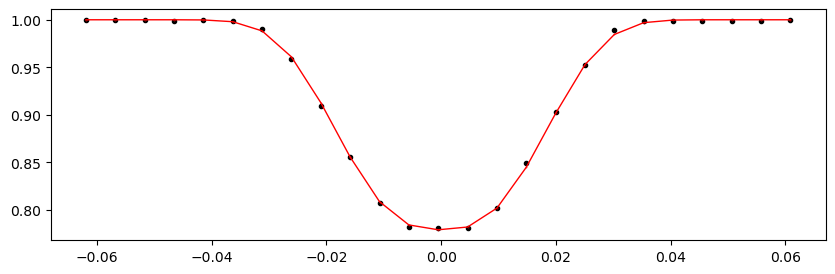

55390.431320897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1231.49it/s]


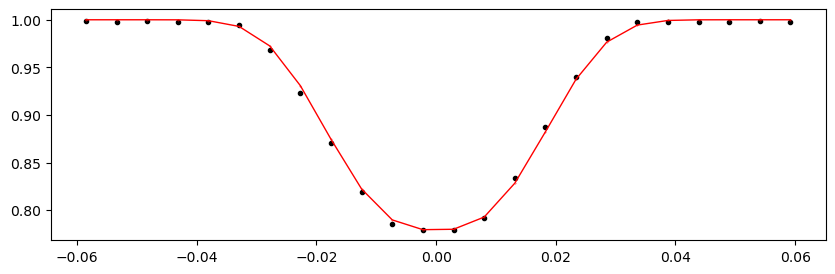

55394.42278089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1264.95it/s]


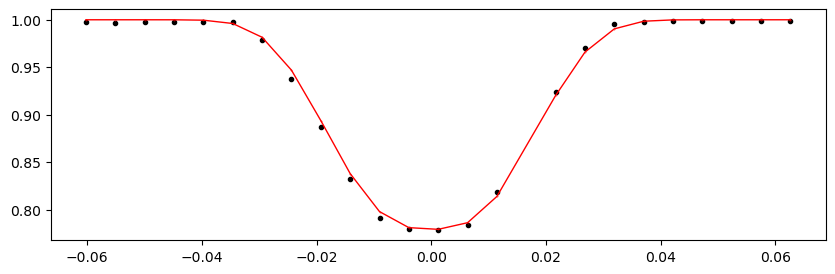

55398.414240898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1257.69it/s]


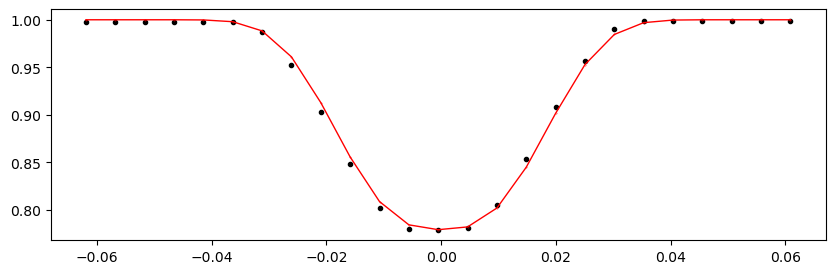

55402.405700897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1200.53it/s]


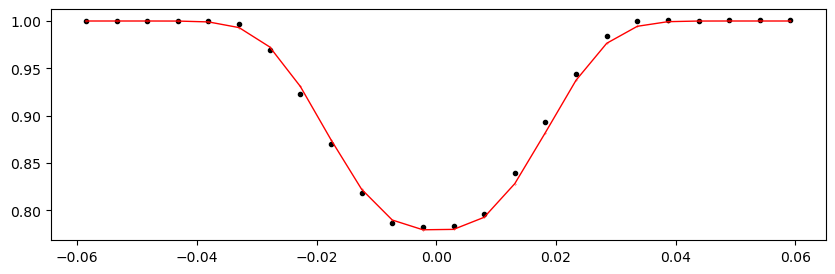

55406.39716089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1212.56it/s]


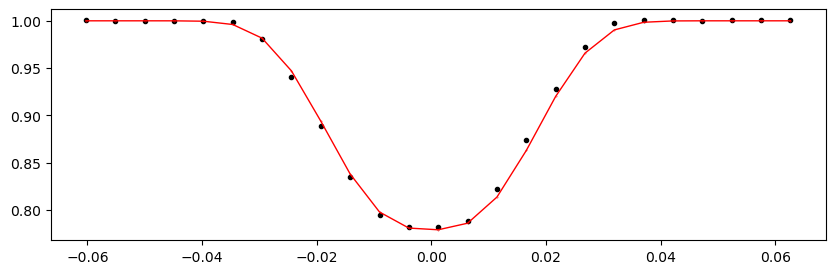

55410.388620898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1190.39it/s]


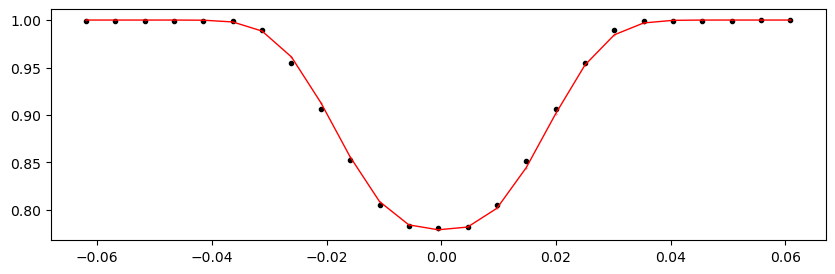

55414.380080897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1185.01it/s]


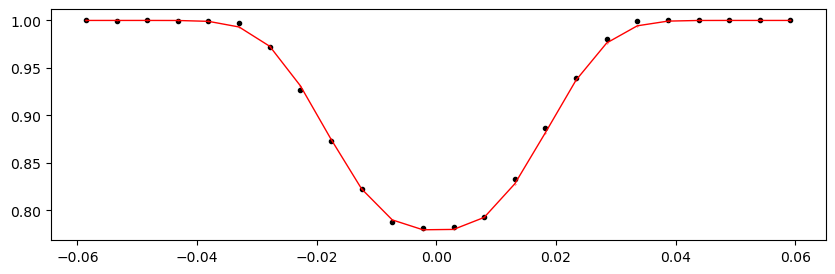

55418.37154089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1174.12it/s]


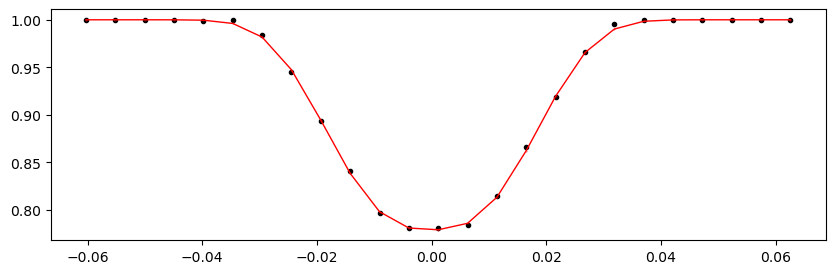

55422.363000897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1215.33it/s]


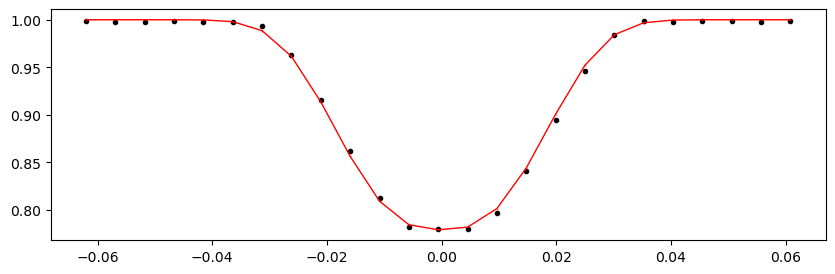

55426.354460897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1207.68it/s]


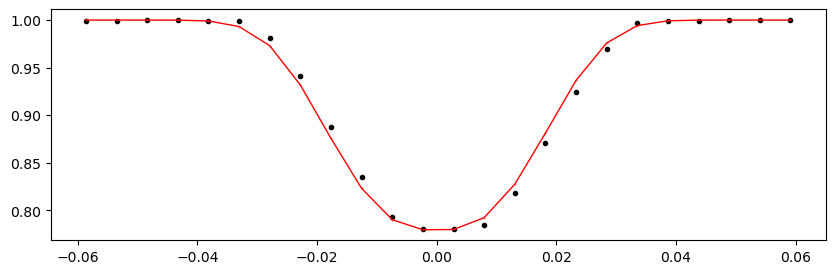

55430.34592089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1206.24it/s]


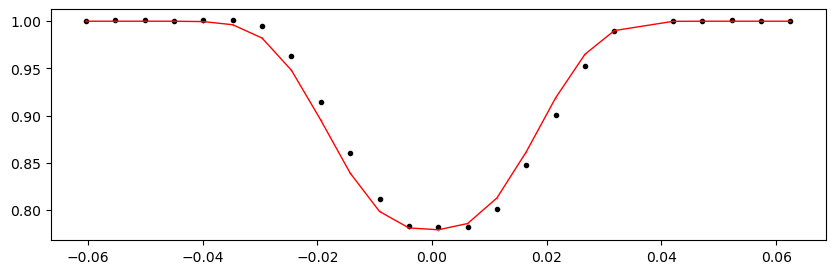

55434.337380897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1191.16it/s]


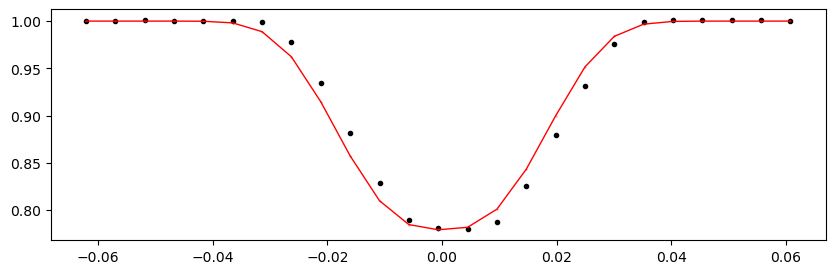

55438.32884089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1172.41it/s]


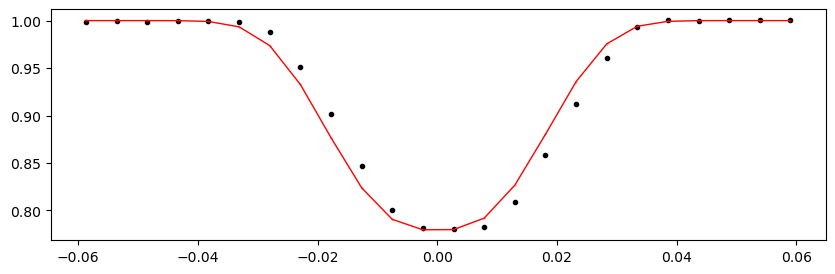

55442.320300898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1188.68it/s]


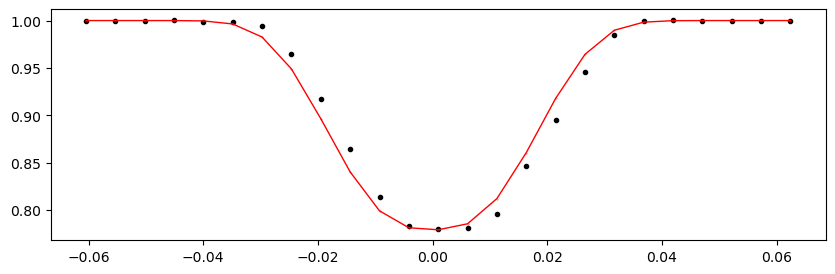

55446.311760897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.41it/s]


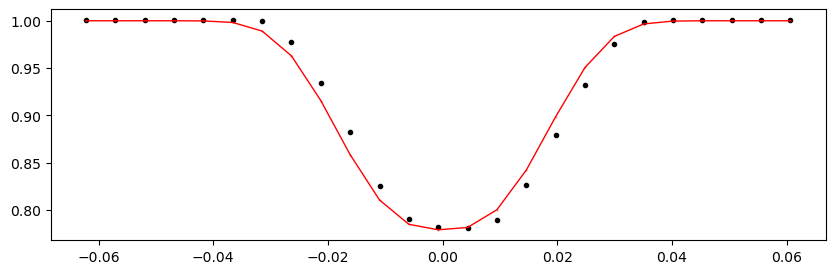

55450.30322089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1186.88it/s]


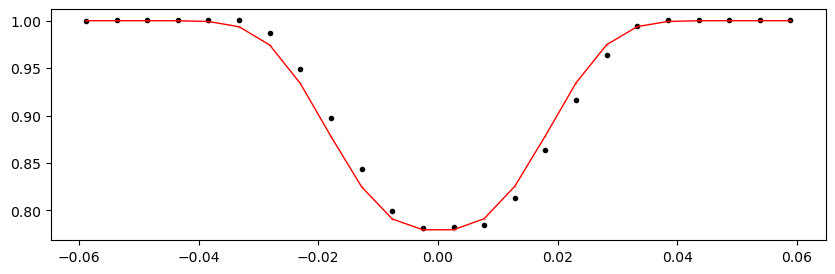

55454.294680898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1192.28it/s]


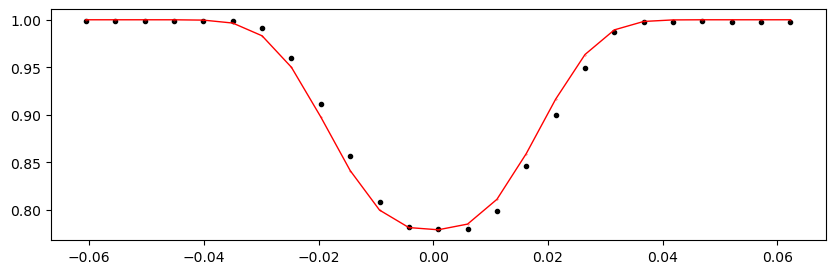

55458.286140897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1192.97it/s]


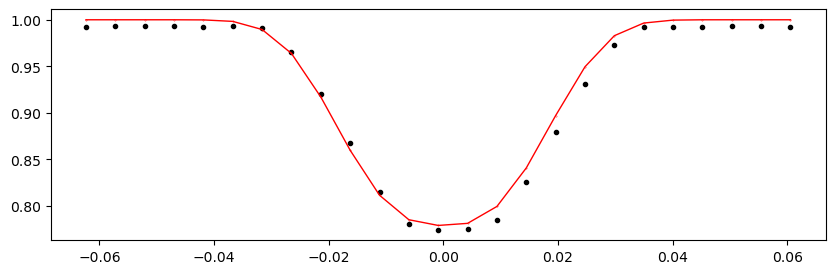

55466.269060898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1201.24it/s]


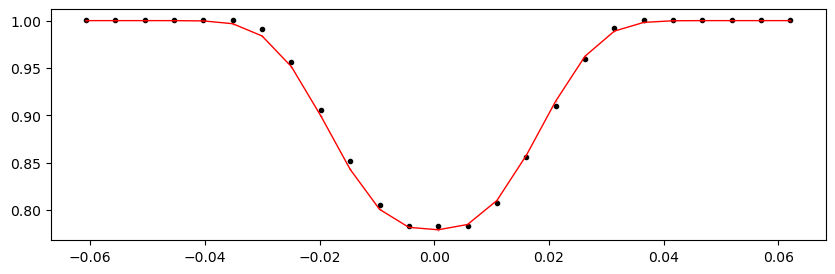

55470.260520897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1212.10it/s]


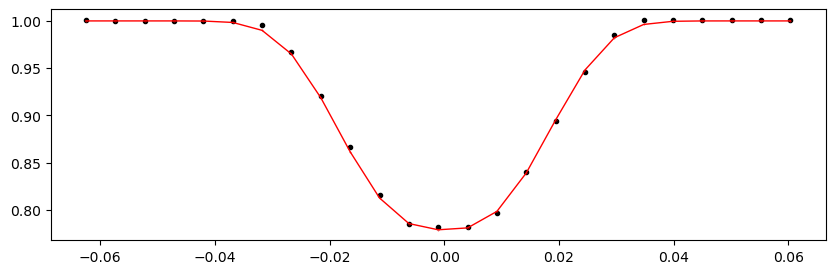

55474.25198089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1207.83it/s]


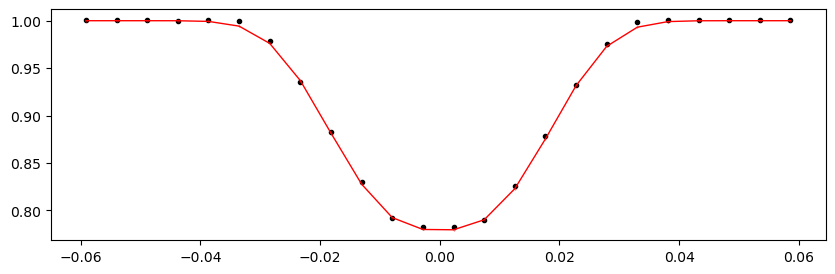

55478.243440898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1177.17it/s]


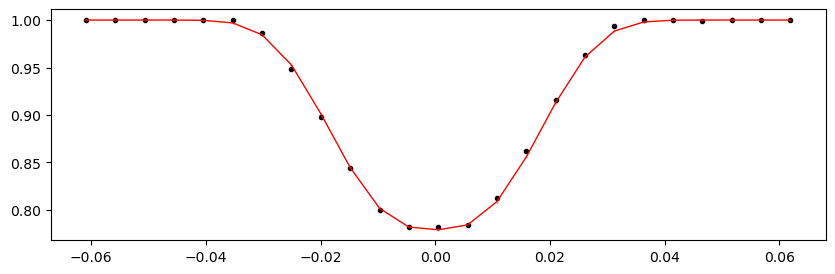

55482.234900897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.34it/s]


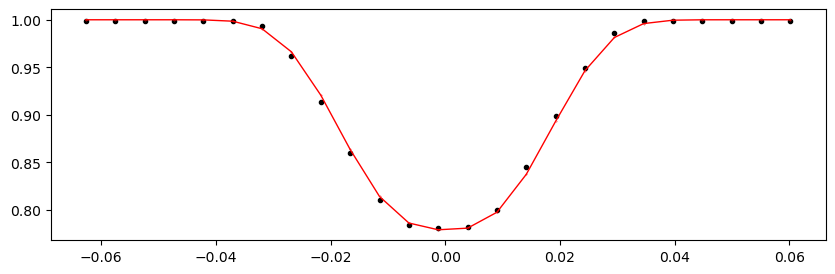

55486.22636089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1176.50it/s]


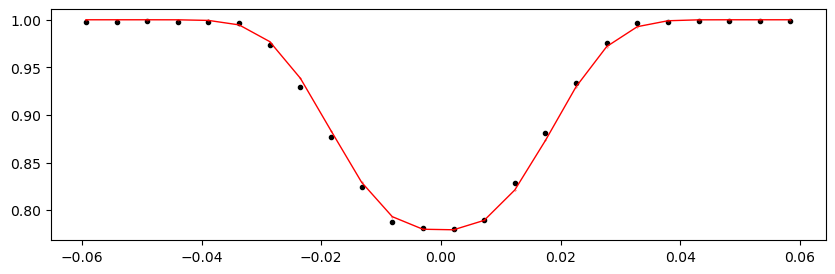

55490.217820898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1194.17it/s]


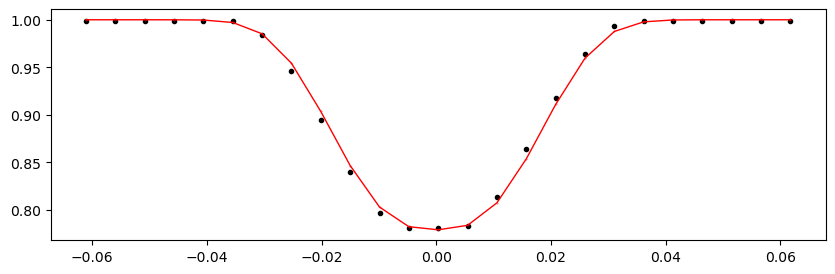

55494.209280897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1175.12it/s]


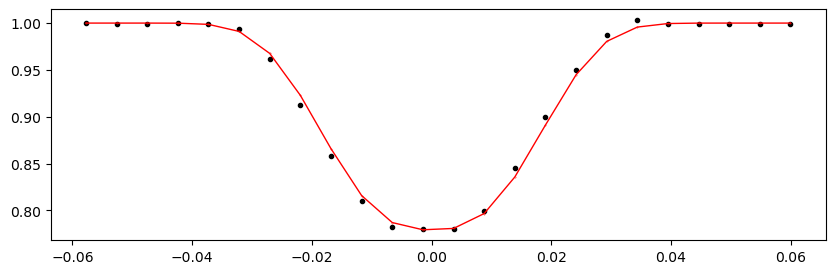

55498.20074089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1177.34it/s]


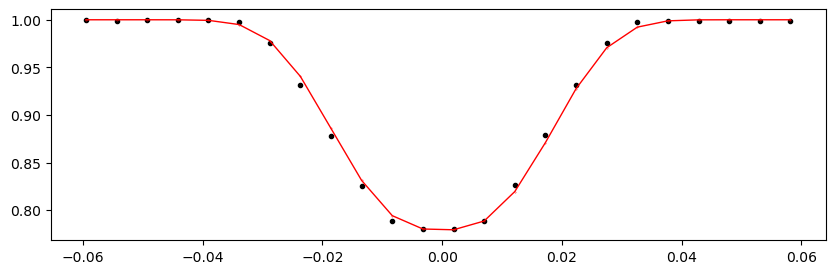

55502.192200898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1213.16it/s]


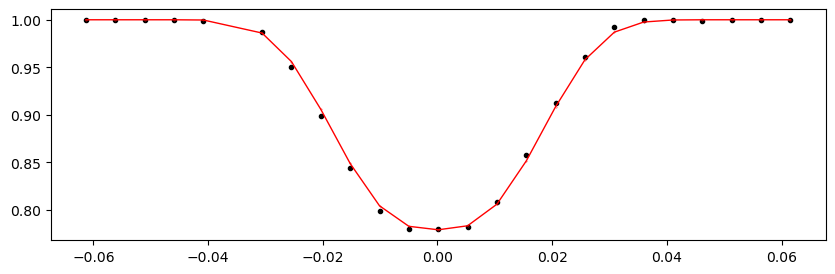

55506.183660897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1222.70it/s]


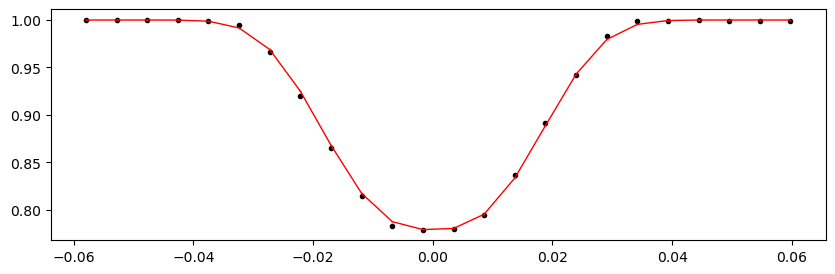

55510.17512089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1203.59it/s]


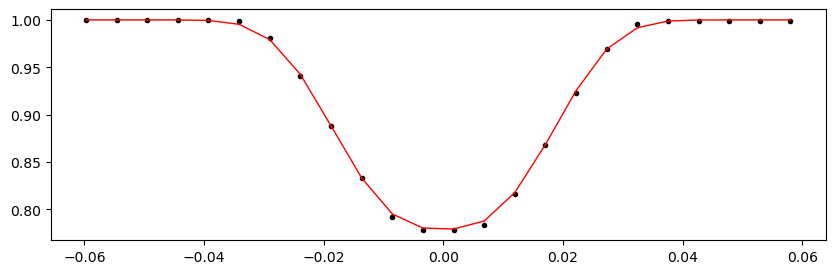

55514.166580897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1191.75it/s]


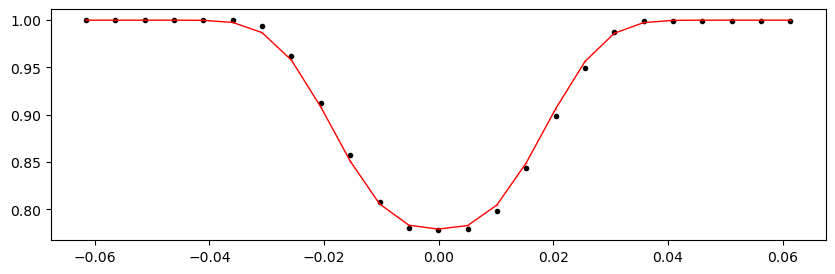

55518.15804089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1211.26it/s]


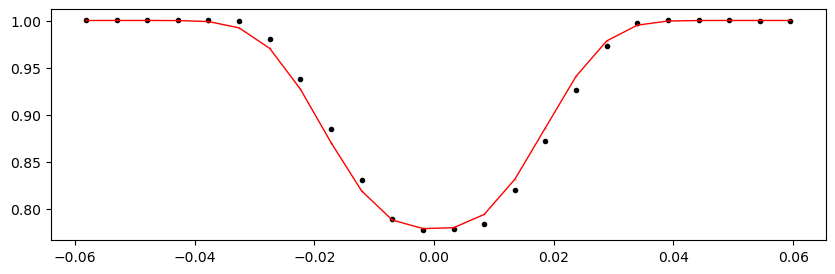

55522.149500898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1175.45it/s]


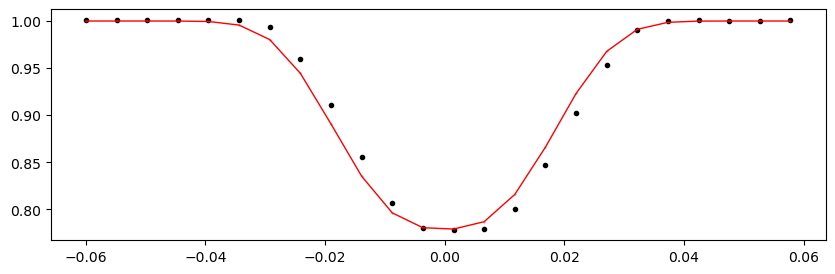

55526.140960897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1208.58it/s]


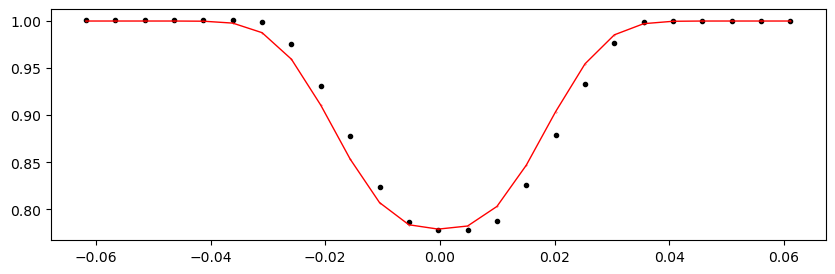

55530.13242089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1198.23it/s]


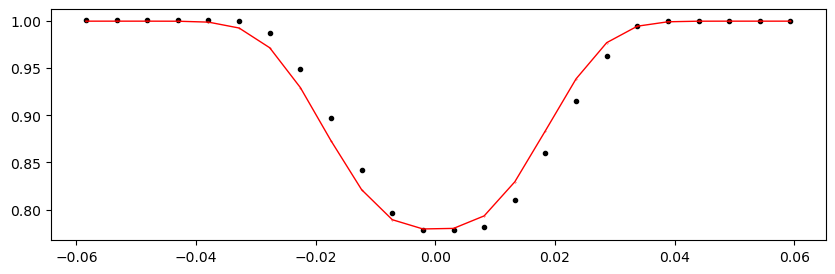

55534.123880898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1200.52it/s]


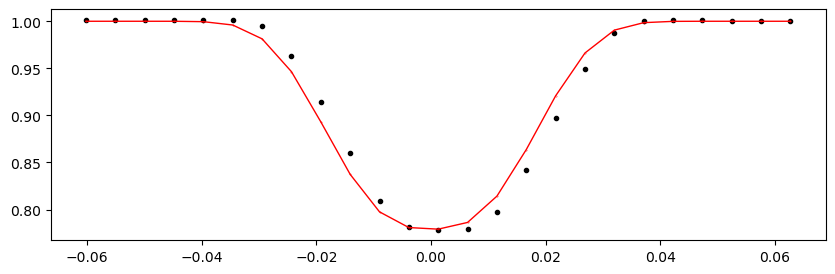

55538.115340897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1189.00it/s]


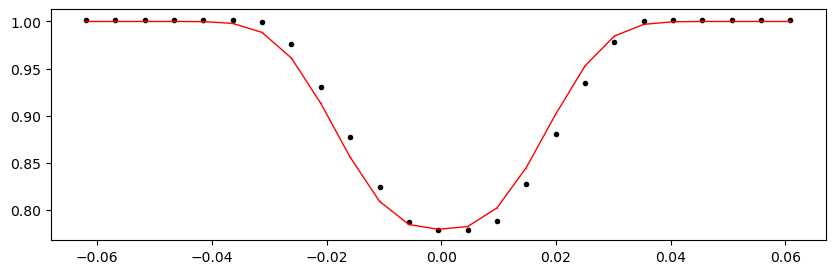

55542.10680089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1213.39it/s]


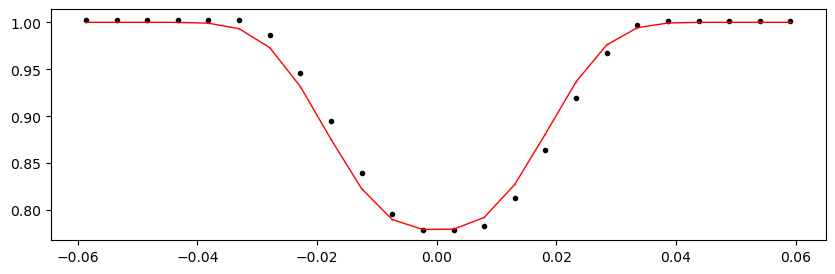

55546.098260898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1209.91it/s]


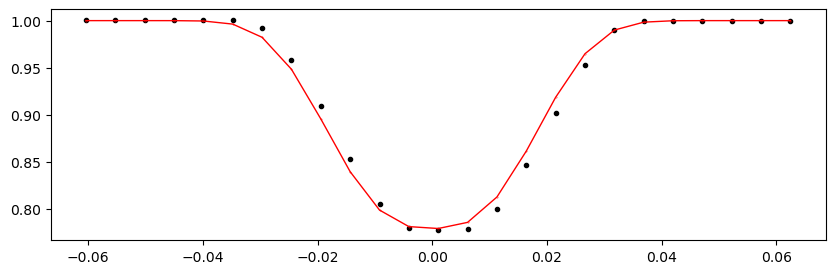

55550.089720897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1181.94it/s]


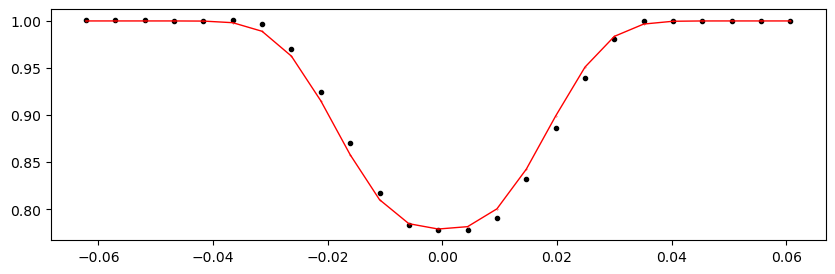

55570.047020898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1182.69it/s]


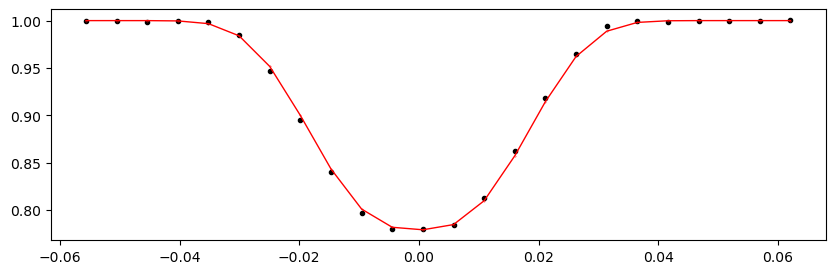

55574.038480897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1204.16it/s]


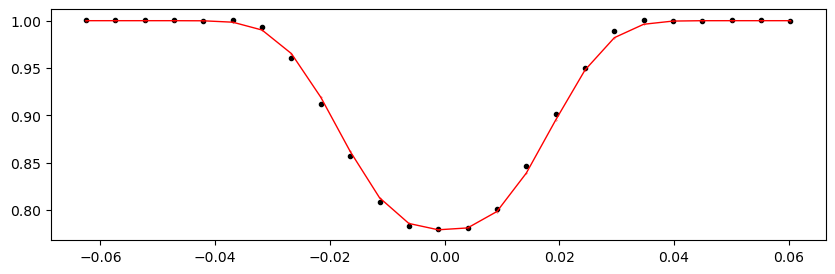

55578.02994089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1180.90it/s]


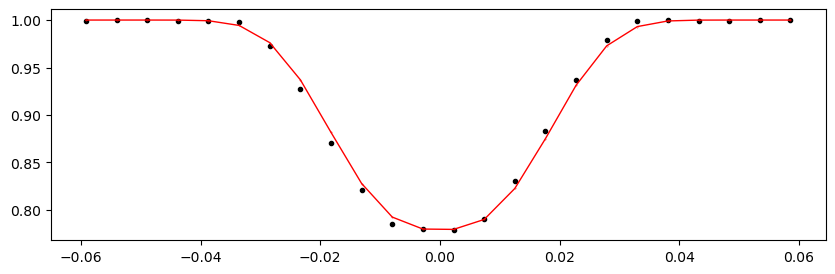

55582.021400898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.29it/s]


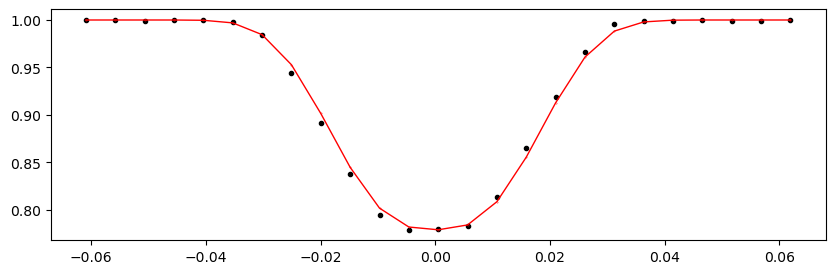

55586.012860897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1214.42it/s]


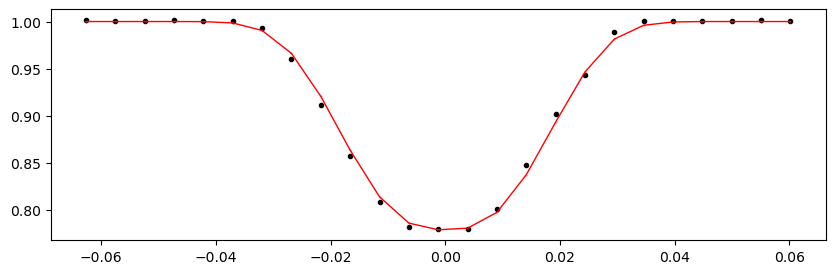

55590.00432089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1194.56it/s]


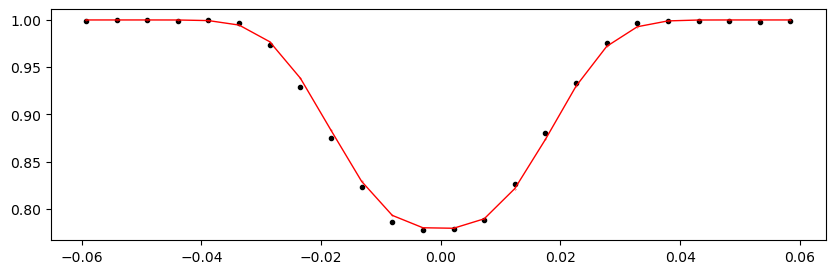

55597.98724089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1202.03it/s]


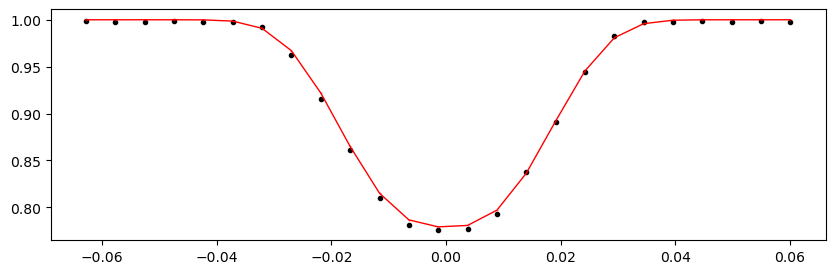

55601.978700898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1218.18it/s]


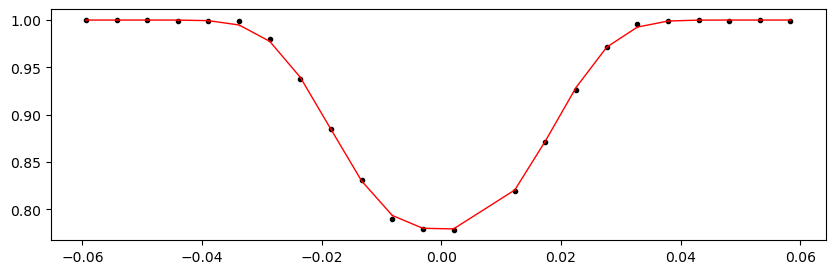

55605.970160897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1192.66it/s]


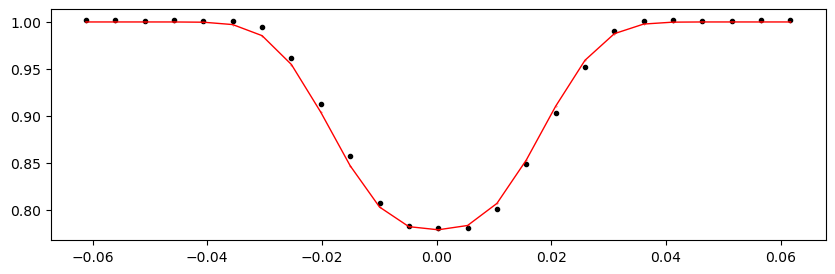

55609.96162089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1229.52it/s]


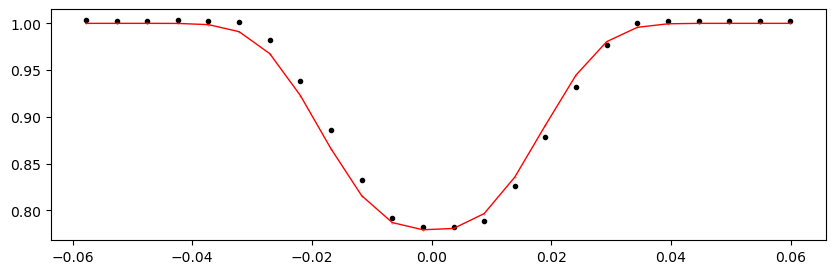

55613.953080898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1194.01it/s]


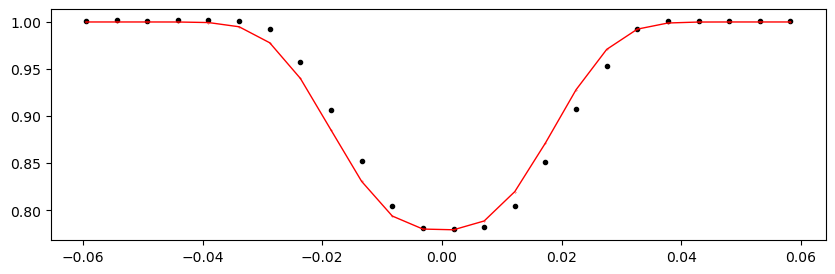

55617.944540897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1214.38it/s]


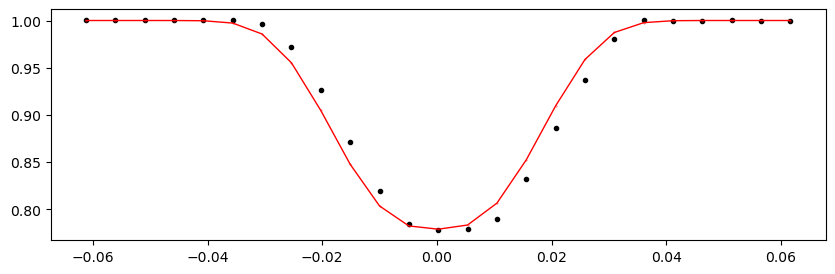

55621.93600089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1216.05it/s]


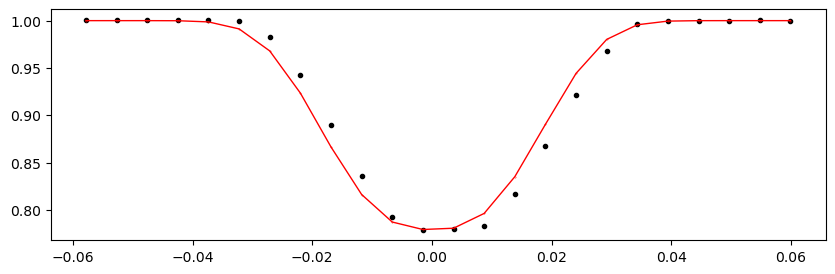

55625.927460898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1212.09it/s]


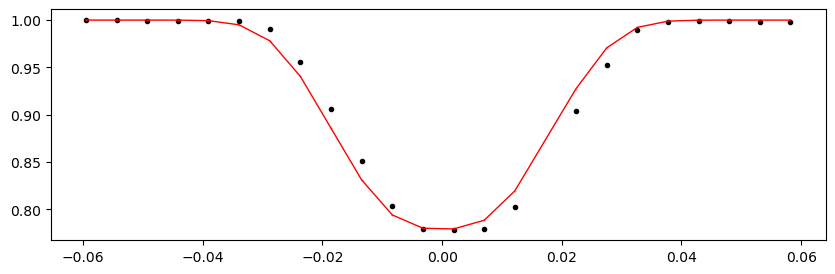

55629.918920897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1198.34it/s]


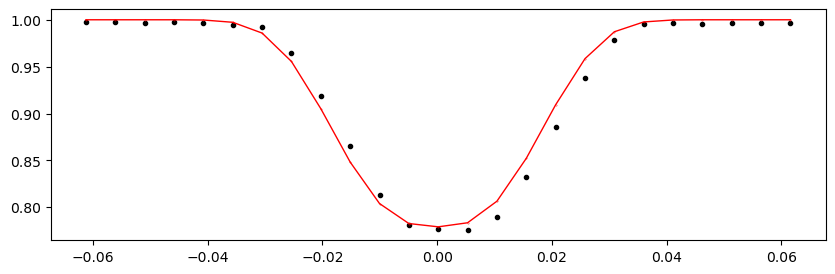

55633.91038089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1186.13it/s]


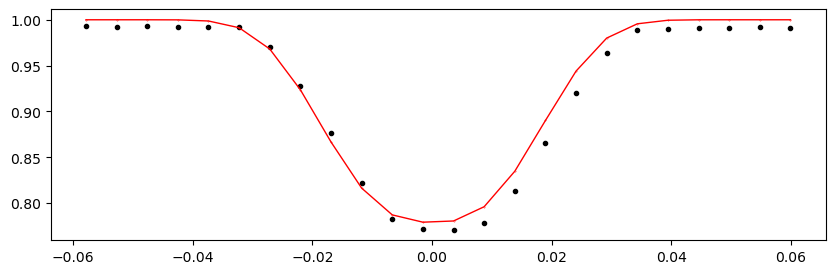

55641.893300897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1193.54it/s]


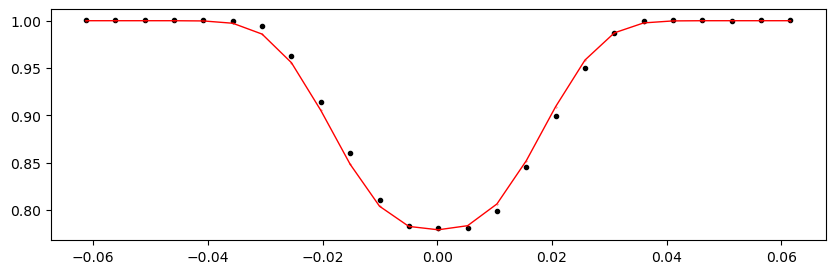

55645.88476089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1165.70it/s]


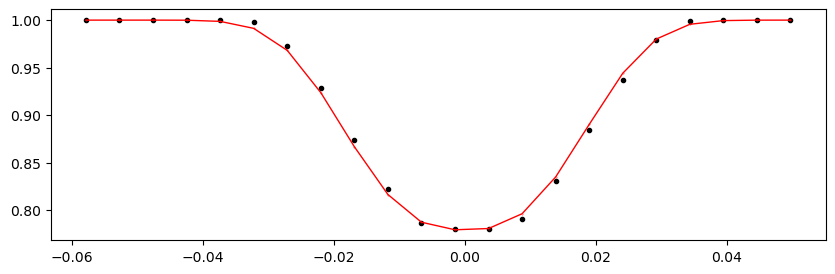

55649.876220898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.58it/s]


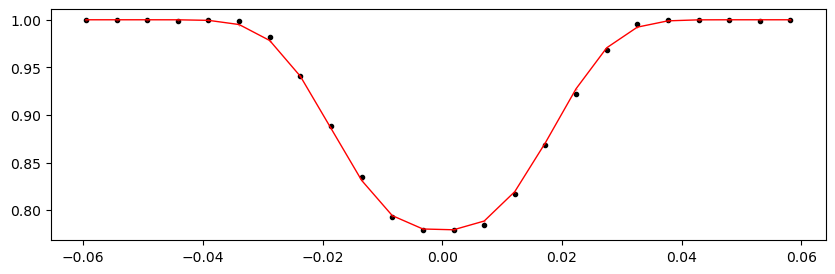

55653.867680897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1164.41it/s]


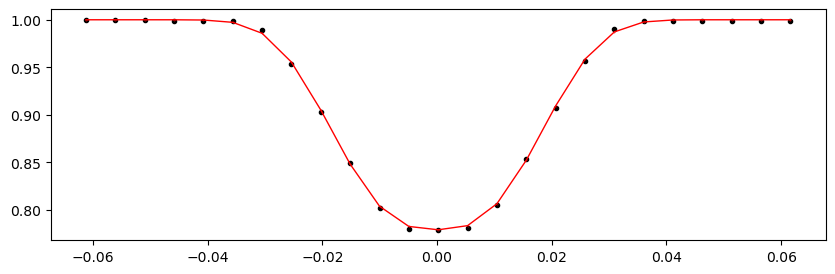

55657.85914089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1182.30it/s]


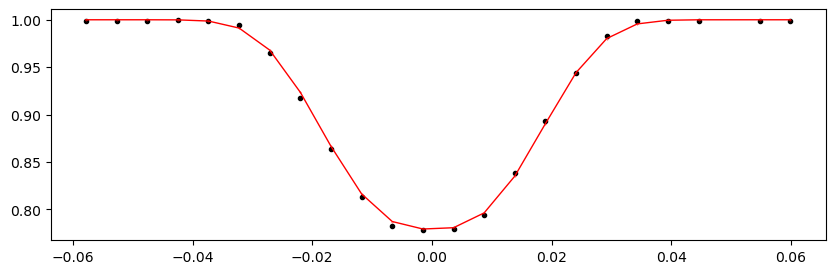

55661.850600898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1207.99it/s]


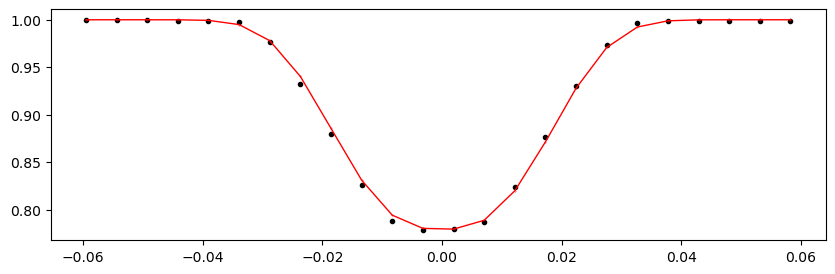

55665.842060897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1212.32it/s]


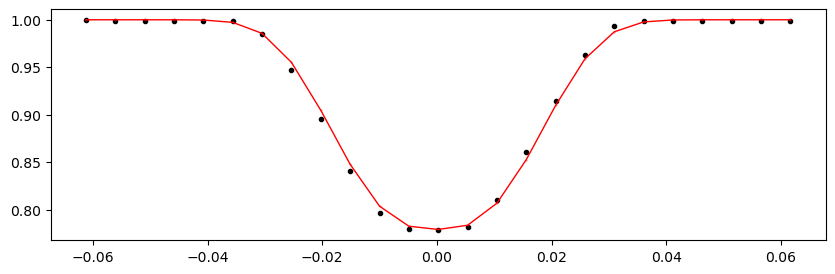

55669.83352089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1201.91it/s]


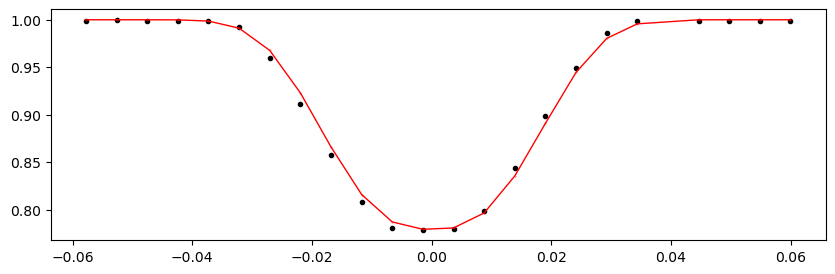

55673.824980897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1185.35it/s]


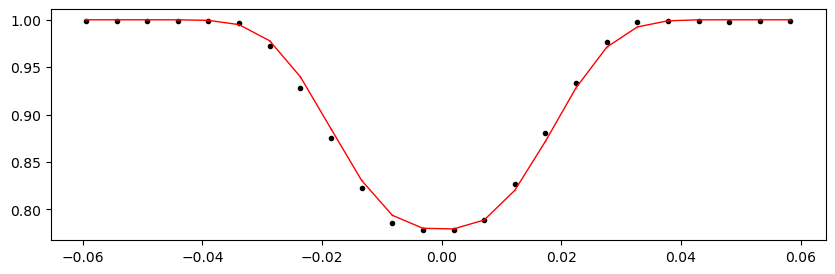

55681.807900898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1164.50it/s]


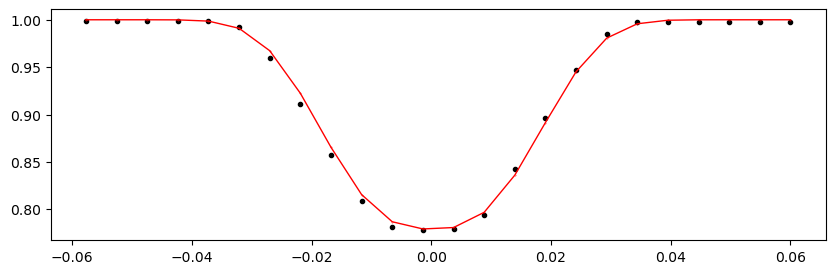

55685.799360897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1216.43it/s]


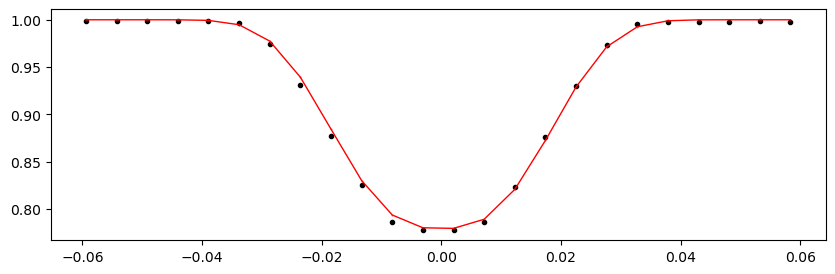

55689.79082089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1199.93it/s]


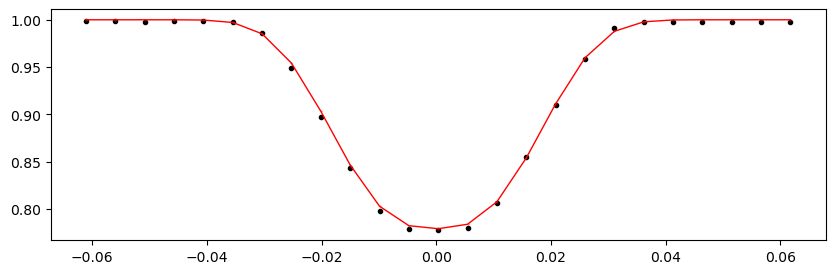

55693.782280898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.51it/s]


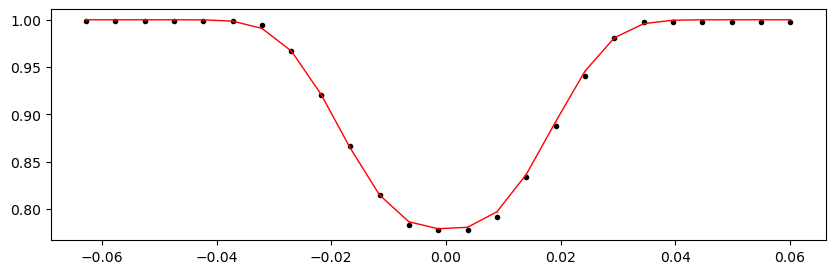

55697.773740897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1204.07it/s]


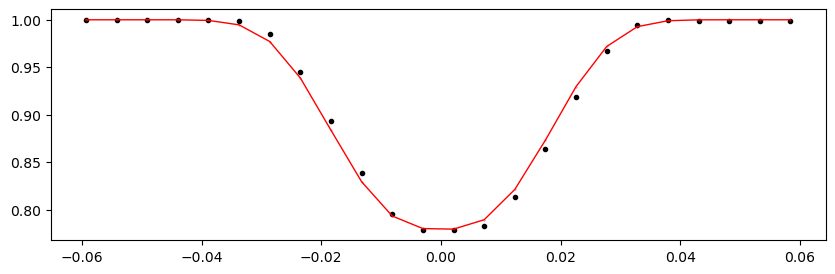

55701.76520089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1196.48it/s]


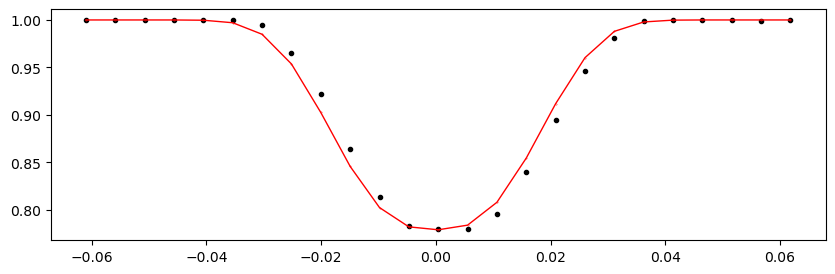

55705.756660898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1165.08it/s]


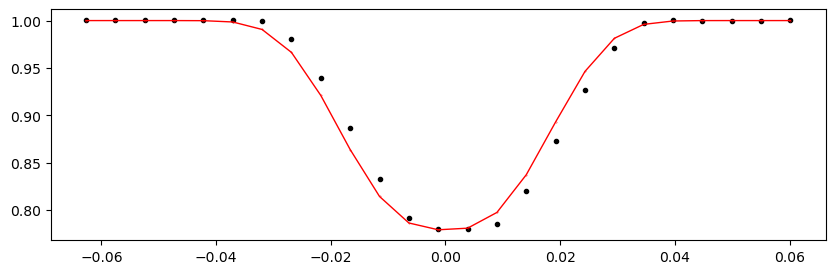

55709.748120897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1205.14it/s]


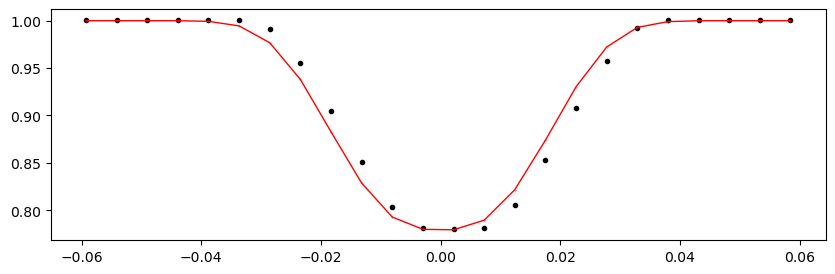

55713.73958089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1200.78it/s]


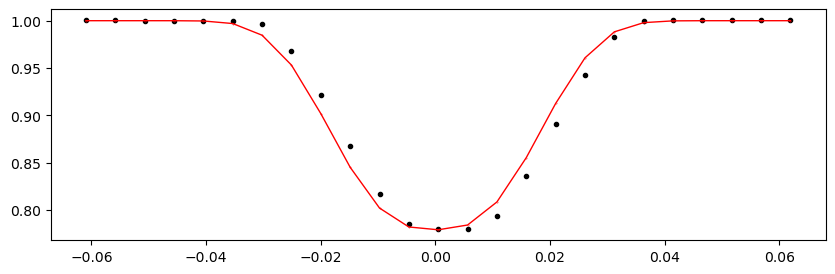

55717.731040898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1205.82it/s]


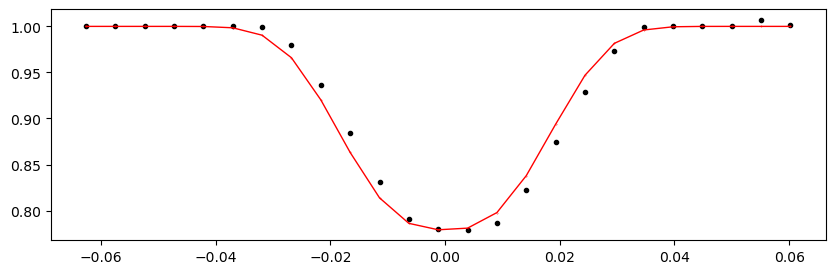

55721.722500897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1165.46it/s]


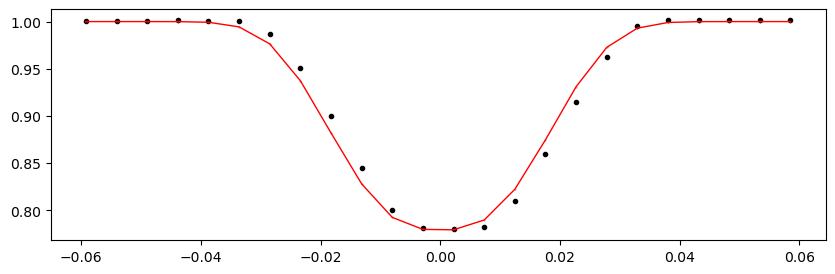

55725.71396089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1198.15it/s]


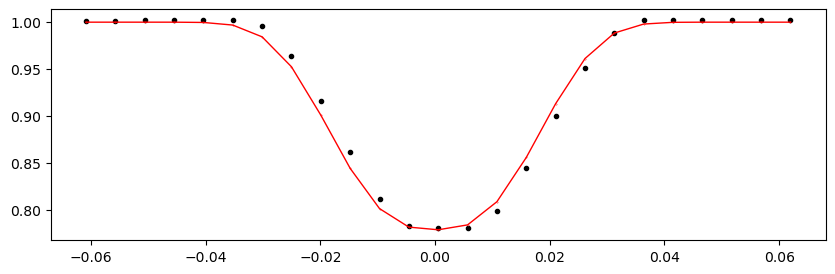

55729.705420898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1216.30it/s]


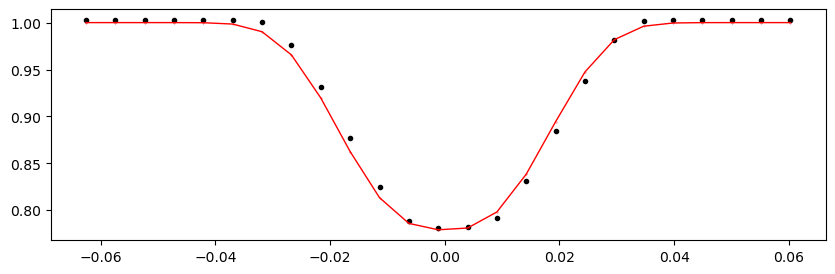

55733.696880897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1183.64it/s]


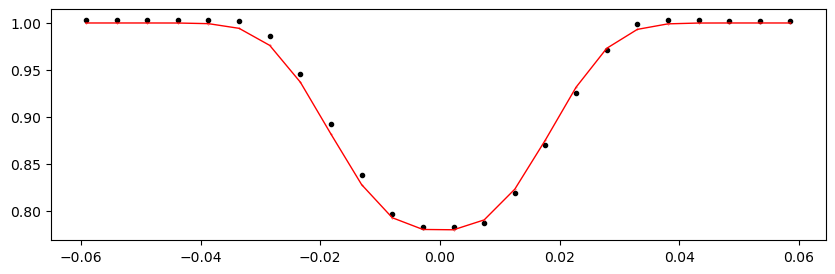

55737.68834089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1181.26it/s]


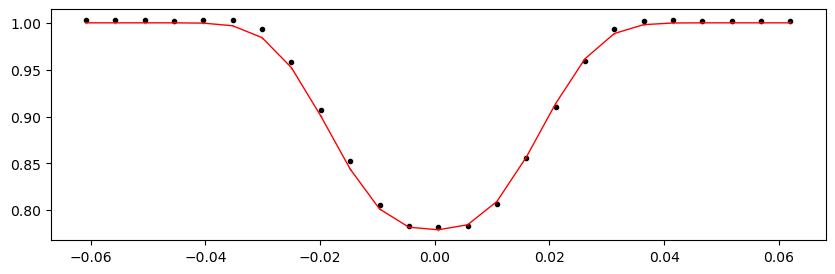

55741.679800898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1207.17it/s]


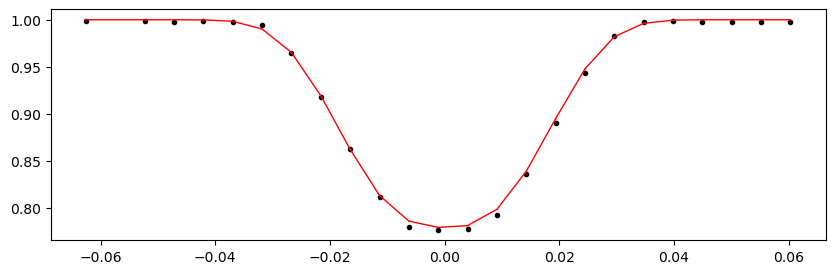

55745.671260897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1192.23it/s]


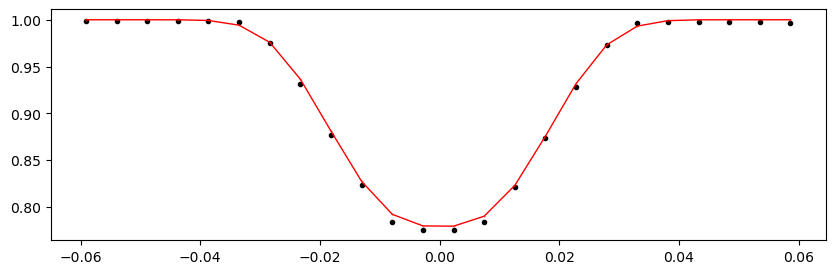

55749.66272089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1190.49it/s]


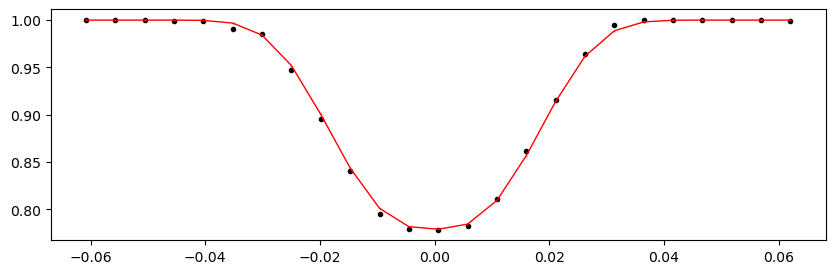

55753.654180898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1200.91it/s]


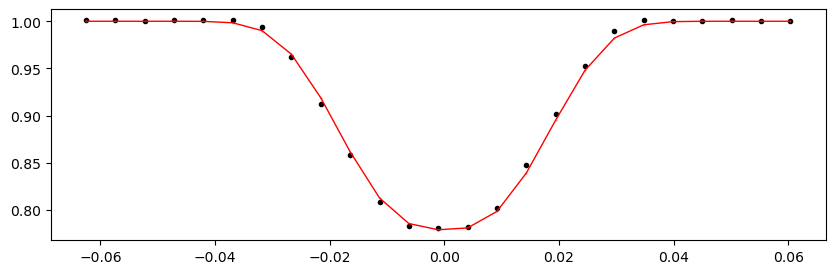

55757.645640897994 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1197.44it/s]


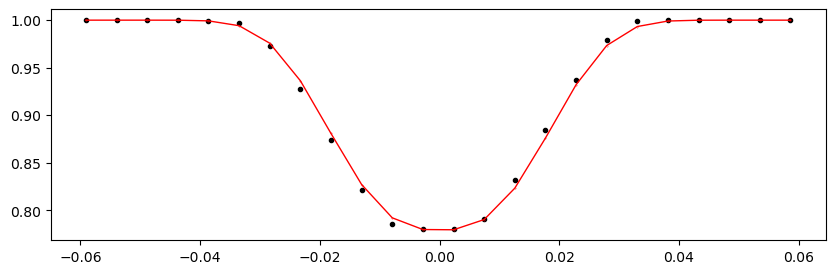

55761.63710089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1185.92it/s]


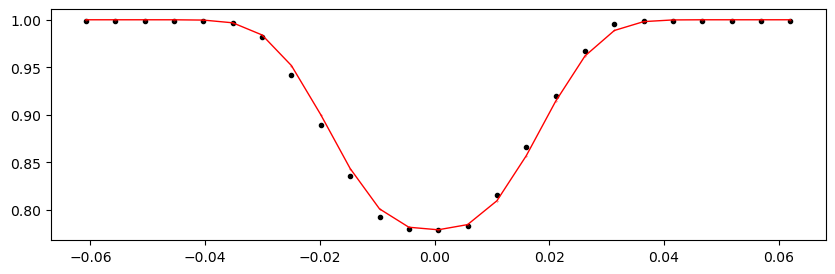

55765.628560897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1207.24it/s]


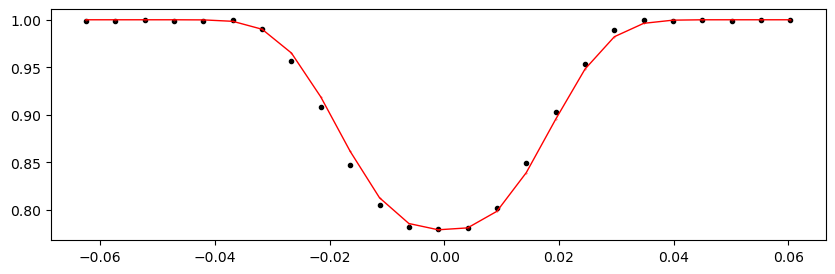

Time 55769.62002089799 does not have enough data points: 4
55773.611480898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1176.78it/s]


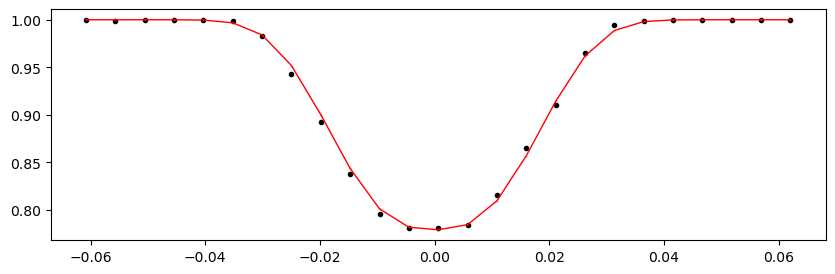

55777.602940897996 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1190.73it/s]


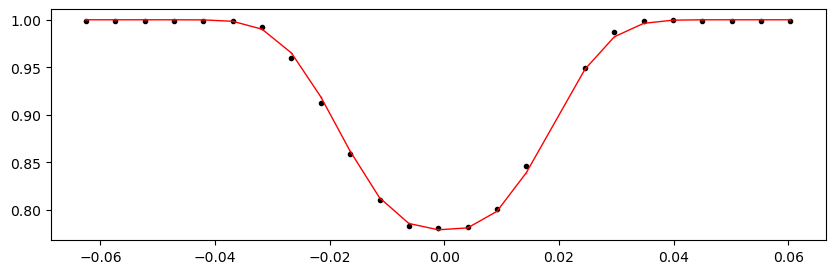

55781.59440089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1195.82it/s]


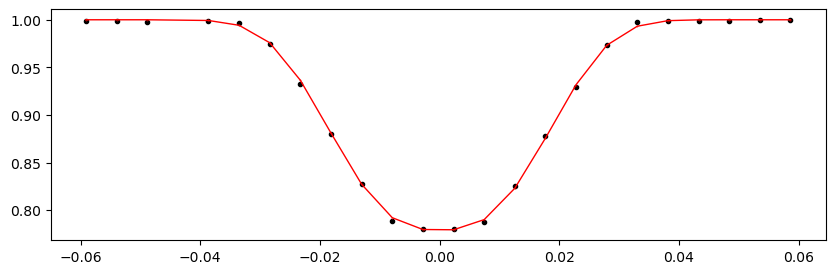

55785.585860898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1204.54it/s]


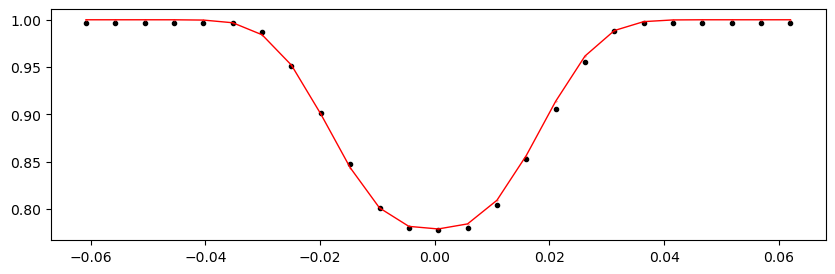

55789.577320897995 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1175.51it/s]


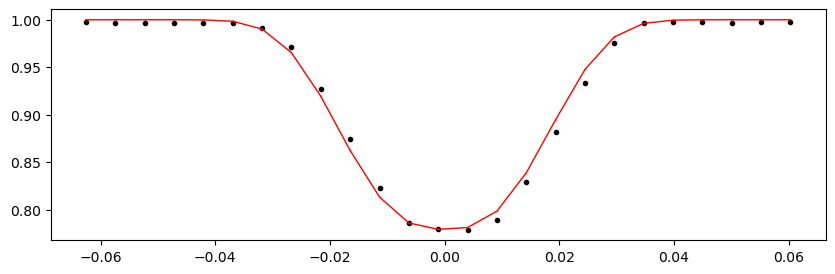

55793.56878089799 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1180.67it/s]


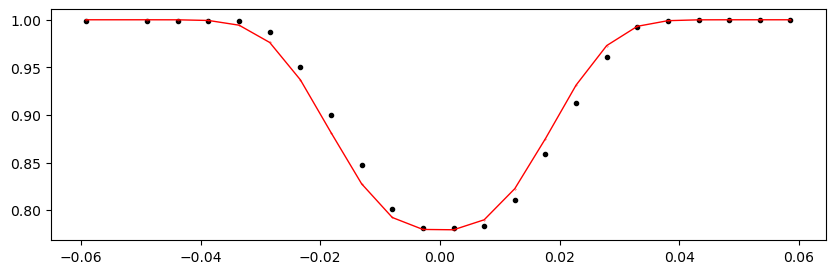

55797.560240898 1.0000198023838813 -0.2209161523632035 -0.32261651494994603


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1173.99it/s]


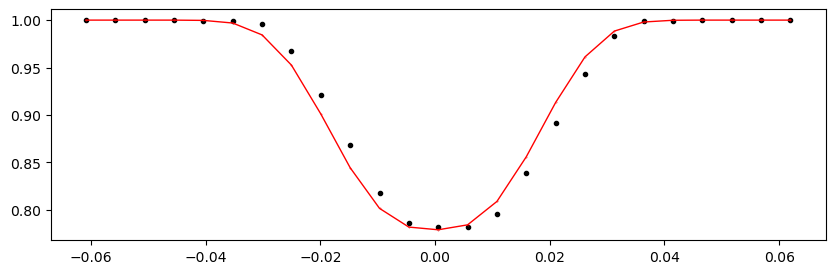

In [37]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# -----

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=9,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

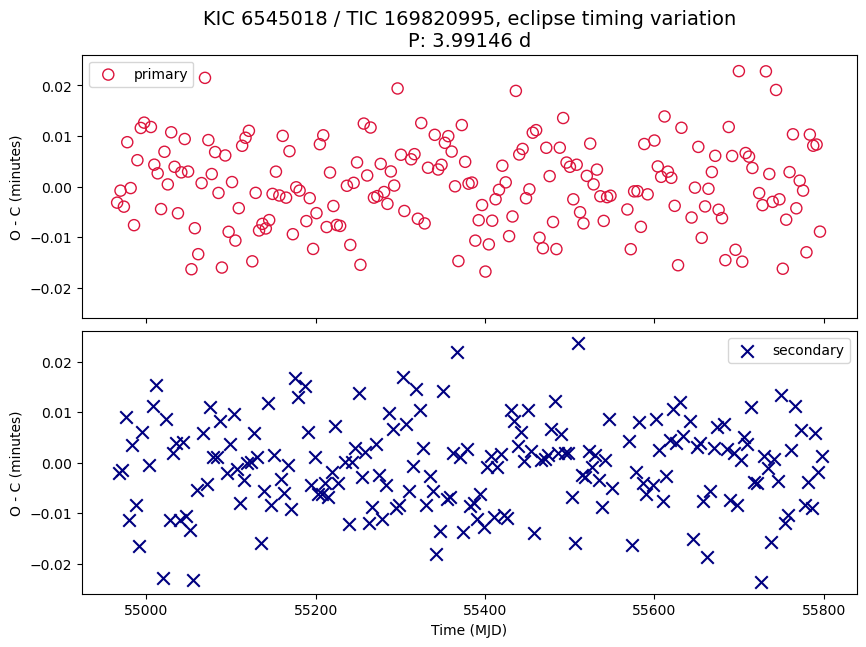

In [38]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True, sharey=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 55800]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 55800]


    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

# ---

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 59000]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 59000]
    in_df_secondary = in_df_secondary[in_df_secondary['shift_mins'] < 10]  # exclude a single outlier

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

    axs[1].set_xlim(axs[1].get_xlim()[0], axs[1].get_xlim()[0] + (axs[0].get_xlim()[1] - axs[0].get_xlim()[0]))  # same X scale

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"KIC {kicid} / TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

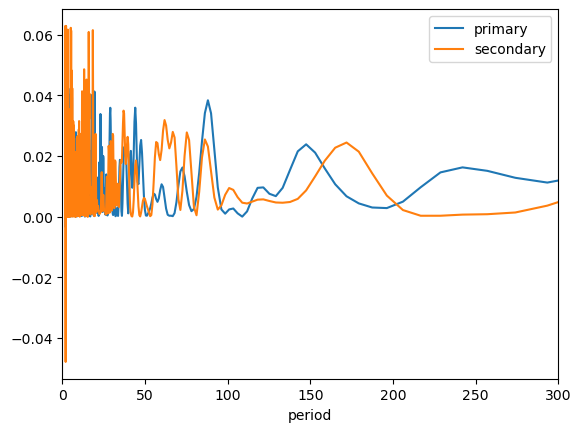

In [40]:
# TESS data roughly has a peak of ~500 days. The period found in Kepler data.
# it's understandably nosier

frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower(minimum_frequency=1 / 1000)  # ensure the max period exceeds ~500 d in the paper

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower(minimum_frequency=1 / 1000)
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 300)
plt.show()


## Results Summary

In [41]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing Kepler ETV in 2013ApJ: failed for both primary and seconary."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),  # counting TESS only
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                         169820995
has_etv                                                                      Practice
comments     Reproducing Kepler ETV in 2013ApJ: failed for both primary and seconary.
period                                                                        3.99146
depth_pct_p                                                                     28.29
depth_pct_s                                                                     22.09
epoch_p                                                                  54965.335642
epoch_s                                                                  54967.336561
num_sectors                                                                        17
time_span                                                                      835.98
time_start                                                                   54964.01
time_end                                                                     55799.99


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
169820995,Practice,Reproducing Kepler ETV in 2013ApJ: failed for both primary and seconary.,3.99146,28.29,22.09,54965.335642,54967.336560897995,17,835.98,54964.01,55799.99

